# Coefficient Estimation for NEWT

At this point, we have established that, with the available periods-of-record, a stationary SCHEMA works quite well, though some sort of dynamism is likely to help with longer-range applications.  Still, the emphasis is on short-term and S2S forecasting, so long-range efficiency isn't critical (and, more to the point, can be returned to later).  Now, let's look at coefficient estimation, where dynamic fitting is likely to be more important.

Here's the basic idea.  We want to be able to run a watershed model without pre-feeding years of data, but we also want to benefit from data on atmospheric conditions.  How should we proceed?

- Develop one fit for model coefficients based only on static surface conditions (XYZ, slope and aspect, land cover/LAI, drainage area)
- Develop a separate fit for model coefficients based only on dynamic conditions (mean precipitation, temperature, and humidity; land cover/LAI again; soil moisture; aridity)
- Tune two "drift rates": climate drift (rate of convergence from static-only to climate-only; possibly with a final equilibrium weighting), and recency weight (weighting of climate over time, controlling speed of correction for climate shifts)

For early reporting, I will prototype this with a single model accounting for all data.  Then, I'll build a static-only watershed model generator and a climate-drift model modification engine for the final implementation.

One challenge is that the optimal GAM seems to be *highly* sensitive to the optimization process, since variables may balance or substitute each other in unexpected ways.  Really, the ideal would be a rigorous, global optimization approach.  The problem is that this generates a vast number of possibilities, and it's unclear whether it can be efficiently run: 32 possible predictors.  Though it is quite fast, so maybe it is tractable, at least up to a point (say, all possibilities to an upper limit of 10 predictors).

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
import os
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics, analysis, engines
from NEWT.make_coefficients import build_training_data
import NEXT.data as ndata
import NEWT
from math import ceil
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


In [2]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [3]:
data = pd.read_csv(bp + "DevData.csv", dtype={"id": "str"}, parse_dates=["date"])
data = data[(data["temperature"] > -0.5) & (data["temperature"] < 40)]
data

id       date  temperature       prcp       srad  swe  \
0        13011820 2020-03-31     0.100000  17.110126  248.76216  NaN   
1        13011820 2020-04-01     0.100000   7.202532  403.38873  NaN   
2        13011820 2020-04-02     0.100000   2.167848  600.86993  NaN   
3        13011820 2020-04-03     0.100000   2.987468  509.44165  NaN   
4        13011820 2020-04-04     0.100000   6.021518  465.97583  NaN   
...           ...        ...          ...        ...        ...  ...   
2991921  03047000 2022-12-27     0.540625   0.000000  268.23563  NaN   
2991922  03047000 2022-12-28     0.407292   0.000000  279.93356  NaN   
2991923  03047000 2022-12-29     0.428125   0.000000  290.53482  NaN   
2991924  03047000 2022-12-30     0.661458   0.000000  285.53320  NaN   
2991925  03047000 2022-12-31     0.743750   3.910029  144.37915  NaN   

              tmax  tmin         vp  day  ...  ice_snow          area  \
0         1.795443   NaN  444.26370   91  ...       0.0  7.993837e+07   
1         0.030759   NaN  270.94354   92  ...       0.0  7.993837e+07   
2        -3.442405   NaN  132.77936   93  ...       0.0  7.993837e+07   
3        -2.238481   NaN  138.35303   94  ...       0.0  7.993837e+07   
4         3.509114   NaN  284.43704   95  ...       0.0  7.993837e+07   
...            ...   ...        ...  ...  ...       ...           ...   
2991921  -2.151775   NaN  207.79785  361  ...       0.0  6.878668e+08   
2991922   5.509683   NaN  310.02664  362  ...       0.0  6.878668e+08   
2991923  13.100331   NaN  354.31638  363  ...       0.0  6.878668e+08   
2991924  17.568270   NaN  512.88240  364  ...       0.0  6.878668e+08   
2991925  12.166826   NaN  832.86690  365  ...       0.0  6.878668e+08   

              elev     elev_min    elev_std     slope  asp_north  asp_east  \
0        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
1        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
2        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
3        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
4        2868.2670  2549.556152  130.430969  0.000243   0.003187  0.002841   
...            ...          ...         ...       ...        ...       ...   
2991921   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2991922   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2991923   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2991924   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   
2991925   457.4157   257.871948  133.578278  0.000671   0.004324  0.003170   

               lat         lon  
0        43.807111 -110.178722  
1        43.807111 -110.178722  
2        43.807111 -110.178722  
3        43.807111 -110.178722  
4        43.807111 -110.178722  
...            ...         ...  
2991921  40.458889  -79.449444  
2991922  40.458889  -79.449444  
2991923  40.458889  -79.449444  
2991924  40.458889  -79.449444  
2991925  40.458889  -79.449444  

[2991926 rows x 28 columns]

In [4]:
data.drop(columns="date").describe()

temperature          prcp          srad            swe          tmax  \
count  2.991926e+06  2.991926e+06  2.991926e+06  578973.000000  2.991926e+06   
mean   1.304986e+01  3.422294e+00  3.274390e+02      17.942670  1.688797e+01   
std    7.775644e+00  8.013537e+00  1.310745e+02      49.773732  1.065040e+01   
min   -4.989583e-01  0.000000e+00  1.599158e+01       0.000000 -2.844553e+01   
25%    6.698594e+00  0.000000e+00  2.273116e+02       0.000000  8.676706e+00   
50%    1.256979e+01  0.000000e+00  3.282411e+02       0.000000  1.787338e+01   
75%    1.918229e+01  3.155491e+00  4.292740e+02       7.830607  2.572794e+01   
max    3.999688e+01  2.717640e+02  8.285261e+02     750.342160  4.495986e+01   

               tmin            vp           day         water     developed  \
count  1.434630e+06  2.991926e+06  2.991926e+06  2.991926e+06  2.991926e+06   
mean   5.062781e+00  9.827473e+02  1.872380e+02  1.266922e-02  1.476215e-01   
std    9.422919e+00  6.473607e+02  1.039871e+02  2.059052e-02  2.191586e-01   
min   -3.810106e+01  1.937390e+01  1.000000e+00  0.000000e+00  0.000000e+00   
25%   -1.213380e+00  5.070928e+02  9.900000e+01  1.829815e-03  1.888149e-02   
50%    5.122057e+00  7.727264e+02  1.890000e+02  5.872330e-03  5.986721e-02   
75%    1.198586e+01  1.327171e+03  2.770000e+02  1.543504e-02  1.489284e-01   
max    2.819078e+01  3.693103e+03  3.650000e+02  2.316803e-01  9.849686e-01   

       ...      ice_snow          area          elev      elev_min  \
count  ...  2.991926e+06  2.991926e+06  2.991926e+06  2.991926e+06   
mean   ...  5.767155e-04  5.392987e+09  8.053856e+02  4.412635e+02   
std    ...  3.459909e-03  1.153218e+10  7.761548e+02  5.617260e+02   
min    ...  0.000000e+00  8.833804e+05  1.203066e+01 -8.578022e+01   
25%    ...  0.000000e+00  1.247376e+08  2.667484e+02  1.085327e+02   
50%    ...  0.000000e+00  6.558886e+08  4.574157e+02  2.430432e+02   
75%    ...  0.000000e+00  4.034122e+09  1.132412e+03  4.324933e+02   
max    ...  6.341746e-02  9.451191e+10  3.601852e+03  2.880272e+03   

           elev_std         slope     asp_north      asp_east           lat  \
count  2.991926e+06  2.991926e+06  2.991926e+06  2.991926e+06  2.991926e+06   
mean   1.944589e+02  1.884001e-03  7.352713e-03 -1.545758e-03  3.992814e+01   
std    2.216796e+02  2.531372e-03  1.024116e-02  1.523929e-02  4.613072e+00   
min    1.231675e+00  4.762368e-05 -1.538242e-02 -2.824883e-01  2.697500e+01   
25%    3.118108e+01  4.483381e-04  3.460877e-03 -2.773193e-03  3.731277e+01   
50%    1.143489e+02  9.428893e-04  5.018477e-03  2.168743e-03  4.005460e+01   
75%    2.930310e+02  2.337958e-03  8.378913e-03  3.922721e-03  4.325386e+01   
max    1.427199e+03  3.008171e-02  2.041745e-01  1.524249e-02  4.899881e+01   

                lon  
count  2.991926e+06  
mean  -9.567489e+01  
std    1.749280e+01  
min   -1.243930e+02  
25%   -1.120107e+02  
50%   -8.866242e+01  
75%   -8.047336e+01  
max   -6.780389e+01  

[8 rows x 26 columns]

## Add Reach Buffer Data 

For each site, we want 1-km-upstream, 15-m-buffer canopy cover and mean direction.  Conveniently, flow direction maps exactly onto slope aspect of the river itself, since by definition it flows precisely downhill.  Runtime depends on period of record, but is currently averaging 15 seconds per site (suggesting ~4 hours for all of them).

In [5]:
buffer_path = bp + "dev_buffers.csv"
if os.path.exists(buffer_path):
    buffer_data = pd.read_csv(buffer_path, dtype={"id": "str"})
else:
    buffer_data = pd.concat([proc_buffer(row) for row in drs.itertuples()])
    buffer_data.to_csv(buffer_path, index=False)

In [6]:
data["year"] = data["date"].dt.year
data = data.merge(buffer_data, on=["id", "year"])

In [101]:
data.to_csv(bp + "DevDataBuffers.csv", index=False)

## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

In [5]:
silly = kfold(data, lambda x: dummy_modbuilder(x, True), output="results/Silly.csv")
cheat = kfold(data, lambda x: dummy_modbuilder(x, False), output="results/Cheat.csv")

In [6]:
silly.groupby("id").apply(perf_summary, include_groups=False).median()

R2         0.927358
RMSE       2.889678
NSE        0.810347
Pbias      2.989468
Bias       0.369906
MaxMiss    1.845938
dtype: float64

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

A brief test was run and subsequently deleted to establish that simple sinusoid (annual-period, variable-phase sine) does a solid job capturing vp and tmax annual cycles (median R2 0.95 and 0.92, respectively), and therefore those coefficients are suitable here.

In [7]:
coefs = data.groupby("id").apply(lambda x: Watershed.from_data(x).coefs_to_df().drop(columns=["R2", "RMSE"])
                                 if len(x[["day", "temperature"]].dropna()["day"].unique()) >= 181 else None,
                                 include_groups=False).drop(columns=["at_coef", "threshold_act_min"])
coefs.index = coefs.index.get_level_values("id")
# Try normalizing
# coefs["Amplitude"] = coefs["Amplitude"] / coefs["Intercept"]
# coefs["SpringSummer"] = coefs["SpringSummer"] / coefs["Intercept"]
# coefs["FallWinter"] = coefs["FallWinter"] / coefs["Intercept"]
coefs

/u/wy/ch/dphilippus/.conda/envs/next/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/u/wy/ch/dphilippus/.conda/envs/next/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Intercept  Amplitude  FallDay  WinterDay  SpringDay  \
id                                                                     
01010000          8.227527  11.664508    323.0       27.5      120.0   
01011000          8.547659  11.735706    322.0       27.0      120.0   
01018035          9.074948  12.007753    321.0       28.0      120.0   
01038000         10.871231  12.433309    319.0       27.0      169.0   
010642505         8.232986   9.252760    321.0       26.0      122.0   
...                    ...        ...      ...        ...        ...   
385903107210800   7.163091   9.258731    300.0       87.0      143.0   
394220106431500   6.965011   7.357272    324.0       84.0      156.0   
402114105350101   4.352286   7.339022    301.0       88.0      153.0   
404417108524900   9.623788   8.047868    330.0       75.0      157.0   
453004122510301  13.095366   7.200009    330.0       85.0      158.0   

                 SummerDay  SpringSummer  FallWinter  threshold_coef_min  \
id                                                                         
01010000             236.0      1.989669    3.269881            0.002503   
01011000             204.0      2.563314    2.746746            0.011190   
01018035             206.0      1.838306    2.569034            0.052588   
01038000             200.0      0.899632    1.966065            0.113039   
010642505            233.0      1.766506    1.030557            0.162370   
...                    ...           ...         ...                 ...   
385903107210800      201.0      2.083604    1.409694            0.000000   
394220106431500      237.0      2.823831    1.979052            0.083988   
402114105350101      237.0      2.495065    0.984321            0.000000   
404417108524900      204.0      1.818095    0.949920           -1.000000   
453004122510301      205.0      0.377075    1.749345           -1.000000   

                 threshold_act_cutoff  threshold_coef_max  
id                                                         
01010000                            8            0.831677  
01011000                            5            0.731417  
01018035                            3            0.828484  
01038000                            4            0.726634  
010642505                          15            0.708612  
...                               ...                 ...  
385903107210800                    11            0.545654  
394220106431500                     3            0.491630  
402114105350101                     2            0.486141  
404417108524900                    -1            0.382719  
453004122510301                    -1            0.675966  

[921 rows x 11 columns]

In [8]:
coefs.describe()

Intercept   Amplitude     FallDay   WinterDay   SpringDay   SummerDay  \
count  921.000000  921.000000  921.000000  921.000000  921.000000  921.000000   
mean    12.740453    8.882257  326.754615   66.920738  154.070575  217.706840   
std      3.993507    2.723280   15.606734   32.471655   21.642059   17.322166   
min      3.085846    0.182583  300.000000    1.000000  120.000000  200.000000   
25%      9.907242    7.209934  317.000000   33.000000  135.000000  200.000000   
50%     12.520833    9.357408  327.000000   84.000000  156.000000  212.000000   
75%     14.876002   10.884484  333.000000   90.000000  177.000000  238.000000   
max     30.100749   15.907383  365.000000  110.000000  180.000000  240.000000   

       SpringSummer  FallWinter  threshold_coef_min  threshold_act_cutoff  \
count    921.000000  921.000000          921.000000            921.000000   
mean       0.739229    1.398353           -0.168556              6.507058   
std        0.955179    0.920338            0.615639              7.795219   
min       -2.585014   -2.453322           -1.000000             -1.000000   
25%        0.062890    0.828810           -1.000000             -1.000000   
50%        0.471416    1.409035            0.080158              4.000000   
75%        1.199086    1.924694            0.301539             11.000000   
max        4.922727    4.801733            1.000000             28.000000   

       threshold_coef_max  
count          921.000000  
mean             0.557811  
std              0.238837  
min              0.006392  
25%              0.393437  
50%              0.584946  
75%              0.740941  
max              1.000000

General observations:

- Minimum temperature (for threshold) can be computed from seasonality, so doesn't need to be fitted.
- There are non-trivial intercorrelations in seasonality.

Linear results:

- Air temperature coefficient correlates surprisingly well with Intercept, Amplitude, and WinterDay.
- Starting point of the threshold-coefficient doesn't correlate well with anything, but we may be able to get away with assuming that it's ~40% of the maximum.
- 50% of mean stream temperature is explained by mean air temperature alone.
- Threshold cutoff doesn't correlate too well with much, but it does correlate with minimum seasonal temperature and maximum coefficient, which together explain ~80% of its variance.  So probably we should just predict maximum and then calculate the rest under fixed assumptions.
- Maximum sensitivity correlates moderately with Amplitude, but not much else.  But that, we can predict using site data.

Nonlinear correlations:

- Minimum coefficient correlates much better with maximum coefficient; it may be possible to make a halfway-decent nonlinear guess (R2 ~60%).
- Cutoff, likewise, correlates well with the minimum coordinates.  Unclear how independent that is, but we could make a decent guess.
- A fair chunk of max sensitivity is predictable from Amplitude.
- Fully 80% of Intercept is explained by mean air temperature in a nonlinear fashion.

In [9]:
coefs.corr()

Intercept  Amplitude   FallDay  WinterDay  SpringDay  \
Intercept              1.000000   0.131512  0.164127   0.404417   0.369917   
Amplitude              0.131512   1.000000 -0.376684   0.274517  -0.066560   
FallDay                0.164127  -0.376684  1.000000  -0.146802   0.101235   
WinterDay              0.404417   0.274517 -0.146802   1.000000   0.425964   
SpringDay              0.369917  -0.066560  0.101235   0.425964   1.000000   
SummerDay              0.129456  -0.272210  0.353745  -0.200349   0.147555   
SpringSummer          -0.470499  -0.231572  0.021123  -0.393230  -0.263417   
FallWinter             0.084135   0.475000 -0.409584   0.208566   0.020473   
threshold_coef_min    -0.001184   0.420143 -0.169919   0.116248  -0.083413   
threshold_act_cutoff   0.224156   0.248867 -0.078949   0.178062  -0.029148   
threshold_coef_max     0.332195   0.647626 -0.420410   0.431056   0.099114   

                      SummerDay  SpringSummer  FallWinter  threshold_coef_min  \
Intercept              0.129456     -0.470499    0.084135           -0.001184   
Amplitude             -0.272210     -0.231572    0.475000            0.420143   
FallDay                0.353745      0.021123   -0.409584           -0.169919   
WinterDay             -0.200349     -0.393230    0.208566            0.116248   
SpringDay              0.147555     -0.263417    0.020473           -0.083413   
SummerDay              1.000000      0.164909   -0.444835           -0.199438   
SpringSummer           0.164909      1.000000   -0.142387           -0.132641   
FallWinter            -0.444835     -0.142387    1.000000            0.273479   
threshold_coef_min    -0.199438     -0.132641    0.273479            1.000000   
threshold_act_cutoff  -0.081416     -0.149749    0.108184            0.753025   
threshold_coef_max    -0.326741     -0.446436    0.498341            0.415534   

                      threshold_act_cutoff  threshold_coef_max  
Intercept                         0.224156            0.332195  
Amplitude                         0.248867            0.647626  
FallDay                          -0.078949           -0.420410  
WinterDay                         0.178062            0.431056  
SpringDay                        -0.029148            0.099114  
SummerDay                        -0.081416           -0.326741  
SpringSummer                     -0.149749           -0.446436  
FallWinter                        0.108184            0.498341  
threshold_coef_min                0.753025            0.415534  
threshold_act_cutoff              1.000000            0.418928  
threshold_coef_max                0.418928            1.000000

## PCA

In [73]:
co_norm = (coefs - coefs.mean()) / coefs.std()
co_norm.iloc[:, :10]

Intercept  Amplitude   FallDay  WinterDay  SpringDay  \
id                                                                        
01010000        0  -0.943126   1.020460 -0.239062  -1.207480  -1.574790   
01011000        0  -0.874865   1.046572 -0.303112  -1.222831  -1.574790   
01018035        0  -0.762433   1.146347 -0.367163  -1.192130  -1.574790   
01038000        0  -0.379418   1.302420 -0.495264  -1.222831   0.691799   
010642505       0  -0.941962   0.135945 -0.367163  -1.253531  -1.482276   
...                      ...        ...       ...        ...        ...   
385903107210800 0  -1.170092   0.138135 -1.712223   0.619173  -0.510881   
394220106431500 0  -1.212328  -0.559231 -0.175011   0.527073   0.090459   
402114105350101 0  -1.769430  -0.565924 -1.648173   0.649873  -0.048312   
404417108524900 0  -0.645406  -0.305953  0.209292   0.250773   0.136716   
453004122510301 0   0.094826  -0.616907  0.209292   0.557773   0.182973   

                   SummerDay  SpringSummer  FallWinter   at_coef   vp_coef  
id                                                                          
01010000        0   1.057523      1.185340    2.035952 -0.495313  0.335223  
01011000        0  -0.790702      1.723365    1.467359 -0.592296  0.137413  
01018035        0  -0.675188      1.043375    1.274206 -0.305630  0.431983  
01038000        0  -1.021730      0.162987    0.618842 -0.218354  0.366795  
010642505       0   0.884252      0.976034   -0.397956 -0.516314  0.444743  
...                      ...           ...         ...       ...       ...  
385903107210800 0  -0.963973      1.273442    0.014126  0.466665 -0.691027  
394220106431500 0   1.115280      1.967705    0.632957 -0.344901 -0.445304  
402114105350101 0   1.115280      1.659354   -0.448210  0.022142 -0.365879  
404417108524900 0  -0.790702      1.024420   -0.485600 -0.072189 -0.398778  
453004122510301 0  -0.732945     -0.327122    0.383290  1.132283  0.391498  

[923 rows x 10 columns]

There are some nontrivial cross-correlations, so let's see what the principal component axes look like.  Let's limit it to stream properties (10 variables).

In [74]:
pca = PCA()
fit = pca.fit(co_norm.iloc[:, :10])
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.28635317 0.19484294 0.16747634 0.07725998 0.07444256 0.05951356
 0.0512307  0.0416597  0.03223543 0.01498563]
[0.28635317 0.48119611 0.64867245 0.72593242 0.80037498 0.85988854
 0.91111925 0.95277894 0.98501437 1.        ]


Compared to 10 coefficients, we can capture ~95% of the variance with 8 components.  6 components capture 86%.  Doesn't really seem worth pursuing.

<Axes: >

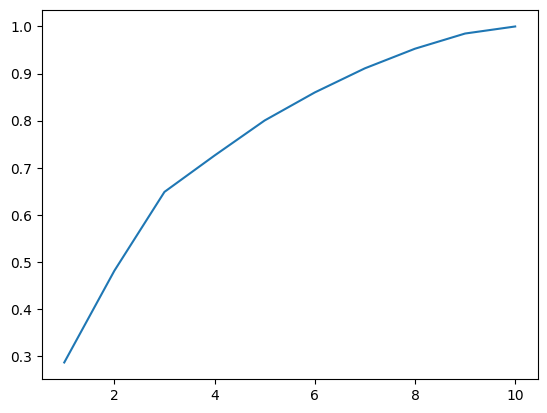

In [75]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

## Coefficient Correlations

### Geography

What's predictable from linear XYZ (plus squared longitude, which gives access to "coasts vs middle")?

In [14]:
coef_xyz = coefs.merge(data[["lat", "lon", "elev", "id"]].groupby("id").mean(), on="id").assign(lon2 = lambda x: (x["lon"] - x["lon"].mean())**2)
coef_xyz

Intercept  Amplitude  FallDay  WinterDay  SpringDay  \
id                                                                     
01010000          8.227527  11.664508    323.0       27.5      120.0   
01011000          8.547659  11.735706    322.0       27.0      120.0   
01018035          9.074948  12.007753    321.0       28.0      120.0   
01038000         10.871231  12.433309    319.0       27.0      169.0   
010642505         8.232986   9.252760    321.0       26.0      122.0   
...                    ...        ...      ...        ...        ...   
385903107210800   7.163091   9.258731    300.0       87.0      143.0   
394220106431500   6.965011   7.357272    324.0       84.0      156.0   
402114105350101   4.352286   7.339022    301.0       88.0      153.0   
404417108524900   9.623788   8.047868    330.0       75.0      157.0   
453004122510301  13.095366   7.200009    330.0       85.0      158.0   

                 SummerDay  SpringSummer  FallWinter  threshold_coef_min  \
id                                                                         
01010000             236.0      1.989669    3.269881            0.002503   
01011000             204.0      2.563314    2.746746            0.011190   
01018035             206.0      1.838306    2.569034            0.052588   
01038000             200.0      0.899632    1.966065            0.113039   
010642505            233.0      1.766506    1.030557            0.162370   
...                    ...           ...         ...                 ...   
385903107210800      201.0      2.083604    1.409694            0.000000   
394220106431500      237.0      2.823831    1.979052            0.083988   
402114105350101      237.0      2.495065    0.984321            0.000000   
404417108524900      204.0      1.818095    0.949920           -1.000000   
453004122510301      205.0      0.377075    1.749345           -1.000000   

                 threshold_act_cutoff  threshold_coef_max        lat  \
id                                                                     
01010000                            8            0.831677  46.700556   
01011000                            5            0.731417  47.069722   
01018035                            3            0.828484  46.181111   
01038000                            4            0.726634  44.222778   
010642505                          15            0.708612  44.083889   
...                               ...                 ...        ...   
385903107210800                    11            0.545654  38.988361   
394220106431500                     3            0.491630  39.705000   
402114105350101                     2            0.486141  40.353861   
404417108524900                    -1            0.382719  40.738056   
453004122510301                    -1            0.675966  45.500951   

                        lon        elev        lon2  
id                                                   
01010000         -69.715556   421.54080  574.079914  
01011000         -69.079444   362.70602  604.966956  
01018035         -67.803889   175.52219  669.341318  
01038000         -69.593889   109.47253  579.924977  
010642505        -71.285556   704.23030  501.310525  
...                     ...         ...         ...  
385903107210800 -107.348489  2647.72120  186.950067  
394220106431500 -106.725833  3027.49410  170.310666  
402114105350101 -105.584139  3229.42850  141.815194  
404417108524900 -108.880278  1733.41830  231.184647  
453004122510301 -122.852045   105.58100  851.269587  

[921 rows x 15 columns]

Intercept, Amplitude, SpringSummer, and air temperature variation are partially explained by XYZ, while mean air temperature and all of humidity are quite well explained.  Seasonality dates are very poorly explained.

In [15]:
coef_xyz.corr()[["lat", "lon", "elev", "lon2"]]**2

lat       lon      elev      lon2
Intercept             0.667396  0.096408  0.257884  0.140177
Amplitude             0.000313  0.242490  0.060249  0.256743
FallDay               0.041793  0.000059  0.010131  0.023948
WinterDay             0.161135  0.048865  0.017276  0.088717
SpringDay             0.170792  0.007624  0.020739  0.022428
SummerDay             0.031549  0.001427  0.002996  0.000014
SpringSummer          0.192821  0.205323  0.274848  0.129371
FallWinter            0.002041  0.010203  0.021554  0.047592
threshold_coef_min    0.000471  0.038222  0.002761  0.023880
threshold_act_cutoff  0.028043  0.024190  0.026327  0.018075
threshold_coef_max    0.054123  0.272983  0.155230  0.196944
lat                   1.000000  0.101007  0.051262  0.209303
lon                   0.101007  1.000000  0.402015  0.363357
elev                  0.051262  0.402015  1.000000  0.059947
lon2                  0.209303  0.363357  0.059947  1.000000

# Stationary Model

For preliminary prototyping, we'll use a GAM and see if we can pull some bits out later.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).  For now, we'll just make a "big model of all the variables", one at a time.

For the stationary model, weather summaries are predictors, not dependent variables.

A fundamental observation: it seems like improvements in the GAM are dominated by threshold behaviors, which is causing it to struggle to achieve good performance.  Possibly a different approach to prototyping would be in order.

## Generalized Code

In [10]:
data.columns

Index(['id', 'date', 'temperature', 'prcp', 'srad', 'swe', 'tmax', 'tmin',
       'vp', 'day', 'water', 'developed', 'barren', 'forest', 'shrubland',
       'herbaceous', 'cultivated', 'wetland', 'ice_snow', 'area', 'elev',
       'elev_min', 'elev_std', 'slope', 'asp_north', 'asp_east', 'lat', 'lon',
       'year', 'canopy', 'flowdir'],
      dtype='object')

In [11]:
pds = coefs.merge(NEWT.coef_est.preprocess(data).drop(columns=["level_1_x", "level_1_y", "date"]),  on="id", how="inner")
Xpd = pds.iloc[:, 12:]
allvar = pds.columns[12:]
pds

id  Intercept  Amplitude  FallDay  WinterDay  SpringDay  \
0           01010000   8.227527  11.664508    323.0       27.5      120.0   
1           01011000   8.547659  11.735706    322.0       27.0      120.0   
2           01018035   9.074948  12.007753    321.0       28.0      120.0   
3           01038000  10.871231  12.433309    319.0       27.0      169.0   
4          010642505   8.232986   9.252760    321.0       26.0      122.0   
..               ...        ...        ...      ...        ...        ...   
916  385903107210800   7.163091   9.258731    300.0       87.0      143.0   
917  394220106431500   6.965011   7.357272    324.0       84.0      156.0   
918  402114105350101   4.352286   7.339022    301.0       88.0      153.0   
919  404417108524900   9.623788   8.047868    330.0       75.0      157.0   
920  453004122510301  13.095366   7.200009    330.0       85.0      158.0   

     SummerDay  SpringSummer  FallWinter  threshold_coef_min  ...  cold_prcp  \
0        236.0      1.989669    3.269881            0.002503  ...   0.665678   
1        204.0      2.563314    2.746746            0.011190  ...   0.666889   
2        206.0      1.838306    2.569034            0.052588  ...   0.347970   
3        200.0      0.899632    1.966065            0.113039  ...   0.333177   
4        233.0      1.766506    1.030557            0.162370  ...   0.547478   
..         ...           ...         ...                 ...  ...        ...   
916      201.0      2.083604    1.409694            0.000000  ...   0.000000   
917      237.0      2.823831    1.979052            0.083988  ...   0.574803   
918      237.0      2.495065    0.984321            0.000000  ...   0.483008   
919      204.0      1.818095    0.949920           -1.000000  ...   0.032035   
920      205.0      0.377075    1.749345           -1.000000  ...   0.018352   

      prcp_sd     srad_sd       vp_sd     ssn_phi  ssn_index  intercept  \
0    5.943128  148.931532  504.397706  216.876912   0.158638   8.787829   
1    6.259149  148.095068  486.744540  224.384931   0.102228   9.763696   
2    6.705198  139.093360  521.265192  253.469434   0.110058  11.344458   
3    8.565124  133.166733  555.611033  239.809530   0.084350  12.411499   
4    8.663051  139.969164  474.622220  262.186041   0.141414  10.084860   
..        ...         ...         ...         ...        ...        ...   
916  3.545819  113.087312  243.660423  186.241206   0.500117  11.893447   
917  3.349789  147.347364  252.754076   47.872008   0.122565   9.466164   
918  4.648200  155.307238  220.697633  172.126836   0.346147   6.876817   
919  2.215789  125.916954  262.787681  220.626578   0.094023  16.928690   
920  5.642897  136.141955  292.062893    5.643142   0.399095  17.051518   

         ksin       kcos       tamp  
0   -6.067253 -15.167896  16.336359  
1   -5.932321 -14.604735  15.763589  
2   -5.606314 -14.288229  15.348754  
3   -5.377854 -12.851322  13.931181  
4   -5.104671 -12.878405  13.853194  
..        ...        ...        ...  
916 -4.284127 -11.356781  12.137966  
917 -3.972916 -10.774711  11.483834  
918 -4.462743 -11.078878  11.943937  
919 -4.684969 -13.954363  14.719822  
920 -3.277676  -9.346154   9.904229  

[921 rows x 41 columns]

In [12]:
allvar

Index(['tmax', 'prcp', 'srad', 'vp', 'area', 'elev_min', 'elev', 'slope',
       'forest', 'wetland', 'developed', 'ice_snow', 'water', 'canopy',
       'flowdir', 'lat', 'lon', 'day', 'frozen', 'cold_prcp', 'prcp_sd',
       'srad_sd', 'vp_sd', 'ssn_phi', 'ssn_index', 'intercept', 'ksin', 'kcos',
       'tamp'],
      dtype='object')

In [14]:
# Reference linear model
X = np.concatenate((np.ones((len(Xpd), 1)), Xpd.to_numpy()), axis=1)
# y = pds.iloc[:, 1:12]
y = pds.iloc[:, 1:12]  # 12
fit = np.linalg.lstsq(X, y, rcond=None)[0]
prd = X @ fit
pd.concat([
    pd.DataFrame({"R2": np.corrcoef(y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[y.columns[i]])
    for i in range(len(y.columns))
])

R2
Intercept             0.879218
Amplitude             0.574248
FallDay               0.256692
WinterDay             0.403881
SpringDay             0.314977
SummerDay             0.222800
SpringSummer          0.508918
FallWinter            0.346179
threshold_coef_min    0.218185
threshold_act_cutoff  0.128373
threshold_coef_max    0.393564

So, that one site (one site!) with a very negative Intercept was seriously screwing things up.  Linear R2 for Intercept is now 0.88, roughly as expected.  That holds similarly if we exclude the monthly data.

Adding aspect values and seasonality indices, our reference linear model is doing *awesome* compared to TempEst 2, with R2s of intercept 0.87 (vs 0.9), amplitude 0.71 (vs 0.65), SpringSummer 0.59 (0.48), FallWinter 0.45 (0.43), WinterDay 0.40 (0.38), SpringDay 0.29, SummerDay 0.22, FallDay 0.24, threshold_coef_min 0.19, threshold_act_cutoff 0.11, threshold_coef_max 0.27 (but those three can use seasonality predictors).  The latter six were not used or not predicted by TempEst 2.

In [15]:
def scatterplots(yv, data=pds, skip=12):
    xv = data.columns[skip:]
    nt = len(xv)
    Ny = 4
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    fig, axes = plt.subplots(Ny, Nx, figsize=(12,10))
    fig.tight_layout()
    for i, term in enumerate(xv):
        ax = axes[i // Nx, i % Nx]
        data.plot.scatter(x=term, y=yv, ax=ax)

def focused_scatters(yv, xv, data=pds):
    sns.pairplot(data, vars=xv+[yv])

def pdps(gam, xy0=True, names=None, ylab=None, save=None):
    nt = len(gam.terms) - 1
    Ny = 1 if nt < 3 else (2 if nt < 9 else 3)
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8))
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx] if Ny > 1 else axes[i]
        if i == 0 and xy0:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_xlabel(repr(term) if names is None else names[i])
        if ylab is not None and i % Nx == 0:
            ax.set_ylabel(ylab)
    plt.tight_layout()
    if save is not None:
        plt.savefig(bp + save)

        
def pdps_by_x(named_gams, savebase):
    # Generate PDPs, as above, but by x-variable, not y-variable.
    # named_gams should be a list of tuples: (gam, xnames, simple_xnames, yname).
    # They will be saved as savebase + simple_xname + .png.
    xes = {}
    for (gam, xns, sxns, yn) in named_gams:
        terms = [t for t in gam.terms if not t.isintercept]
        for (i, sxn) in enumerate(sxns):
            if not sxn in xes:
                xes[sxn] = {"xlab": xns[i], "ys": []}
            gxg = gam.generate_X_grid(term=i)
            X = gxg[:, terms[i].feature]
            pdep, confi = gam.partial_dependence(term=i, X=gxg, width=0.95)
            xes[sxn]["ys"].append((
                yn, X, pdep, confi
            ))
    for (sxn, vals) in xes.items():
        ys = vals["ys"]
        nt = len(ys)
        nrow = int(nt ** 0.5)
        ncol = ceil(nt / nrow)
        _, axes = plt.subplots(nrow, ncol, figsize=(12, 8))
        for (i, Y) in enumerate(ys):
            ax = axes[i // ncol, i % ncol] if nrow > 1 else axes[i] if nt > 1 else axes
            xs = Y[1]
            ax.plot(xs, Y[2])
            ax.plot(xs, Y[3], c='r', ls='--')
            ax.set_ylabel(Y[0])
            if i // ncol == nrow - 1:
                ax.set_xlabel(vals["xlab"])
        plt.tight_layout()
        plt.savefig(savebase + sxn + ".png", dpi=1200)

def get_pd(gam, n):
    XX = gam.generate_X_grid(term=n)
    y = gam.partial_dependence(term=n, X=XX)
    return (XX[:,n], y)


In [53]:
varname = {
    'intercept': "Mean Air Temperature (C)",
     'prcp': "Mean Precipitation (mm/day)",
     'cold_prcp': "Mean Subfreezing Precip (mm/day)",
     'frozen': "Proportion of Days Below Freezing",
     'srad': "Mean Solar Radiation (W/m2)",
     'water': "Water Land Cover Fraction",
     'developed': "Developed Land Cover Fraction",
     'barren': "Barren Land Cover Fraction",
     'forest': "Forest Land Cover Fraction",
     'shrubland': "Shrubland Land Cover Fraction",
     'herbaceous': "Herbaceous Land Cover Fraction",
     'cultivated': "Cultivated Land Cover Fraction",
     'wetland': "Wetland Land Cover Fraction",
     'ice_snow': "Ice/Snow Land Cover Fraction",
     'canopy': "Last-km Riparian Canopy Cover (%)",
     'flowdir': "Mean Last-km Flow Direction (deg)", 
     'area': "Watershed Area (m2)",
     'elev': "Mean Elevation (m)",
     'elev_min': "Min Elevation (m)",
     'slope': "Watershed Mean Slope (m/m)",
     'asp_north': "Slope Aspect Mean North Component",
     'asp_east': "Slope Aspect Mean East Component",
     'lat': "Latitude (deg N)",
     'lon': "Longitude (deg E)",
     'prcp_sd': "Std Dev Precipitation (mm/day)",
     'srad_sd': "Std Dev Solar Radiation (W/m2)",
     'vp': "Std Dev Vapor Pressure (Pa)",
     'ssn_phi': "Mean Date of Precip (Julian day)",
     'ssn_index': "Precip Seasonality Index",
     'tamp': "Annual Air Temperature Amplitude (C)",
     'atmax': "Max Air Temperature (C)",
     'atmin': "Min Air Temperature (C)",
     "Intercept": "3S Intercept (C)",
     "Amplitude": "3S Amplitude (C)"
}
rename = lambda vrs: [varname[v] for v in vrs]

## Intercept

In [20]:
var_itx = ['intercept', 'cold_prcp', 'frozen',
       'area', 'elev_min']
eq_itx = sum([s(i) for i in range(1, len(var_itx))], start=s(0)) # l(0) + s(1)
lam_itx = 10 # 100
gam_itx = LinearGAM(eq_itx, lam=lam_itx).fit(pds[var_itx], pds["Intercept"])
gam_itx.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     32.7796
Link Function:                     IdentityLink Log Likelihood:                                 -1681.9495
Number of Samples:                          921 AIC:                                             3431.4583
                                                AICc:                                            3434.1097
                                                GCV:                                                2.0614
                                                Scale:                                              1.9298
                                                Pseudo R-Squared:                                   0.8832
Feature Function                  Lam

/tmp/ipykernel_3401160/27490146.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_itx.summary()


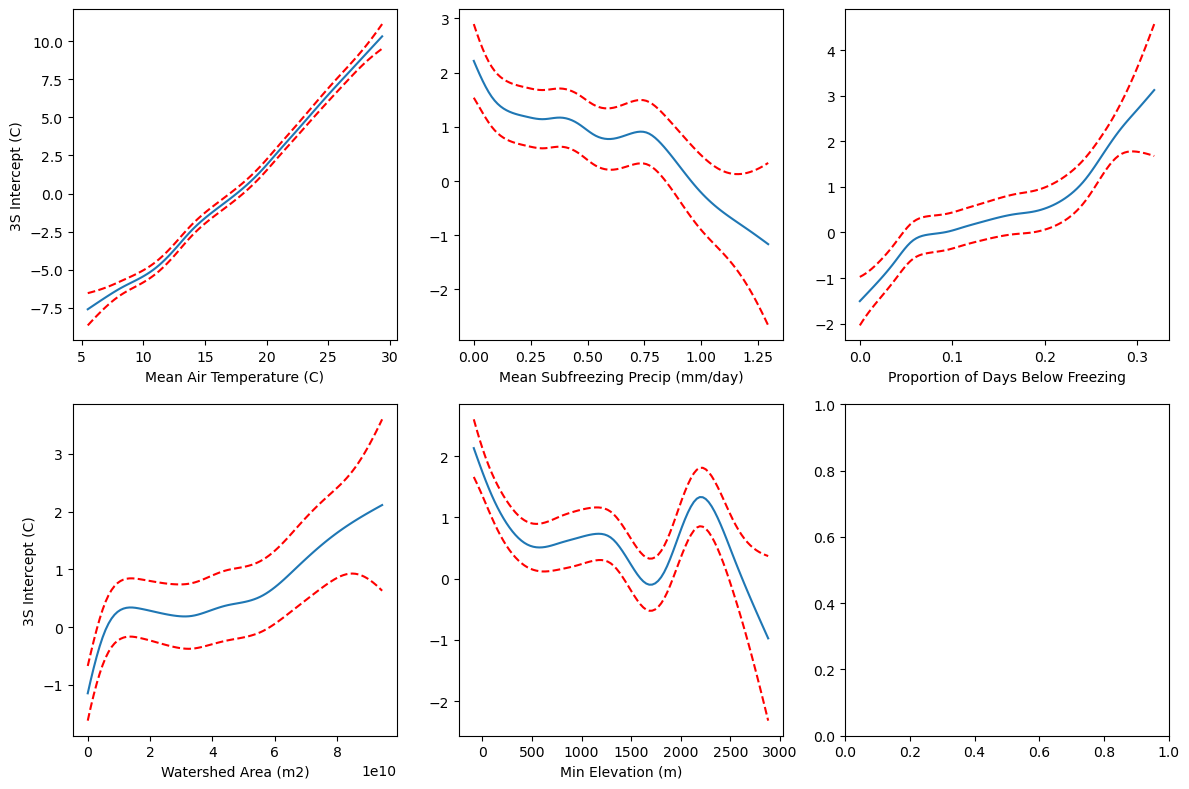

In [21]:
pdps(gam_itx, False, rename(var_itx), "3S Intercept (C)", "results/PDPs/InterceptGAM.png")

## Amplitude

In [28]:
var_amp = ['frozen',
       'water', 'forest', 'area', 'elev', 'elev_min',
       'prcp_sd',
       'vp', 'ssn_phi', 'tamp']
eq_amp = sum([s(i) for i in range(1, len(var_amp))], start=s(0)) #s(0) + s(1) + s(2)
lam_amp = 50
gam_amp = LinearGAM(eq_amp, lam=lam_amp).fit(pds[var_amp], pds["Amplitude"])
gam_amp.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     45.9758
Link Function:                     IdentityLink Log Likelihood:                                 -2032.9443
Number of Samples:                          921 AIC:                                             4159.8402
                                                AICc:                                            4165.0032
                                                GCV:                                                3.4196
                                                Scale:                                              3.1137
                                                Pseudo R-Squared:                                   0.6007
Feature Function                  Lam

/tmp/ipykernel_3401160/188328297.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_amp.summary()


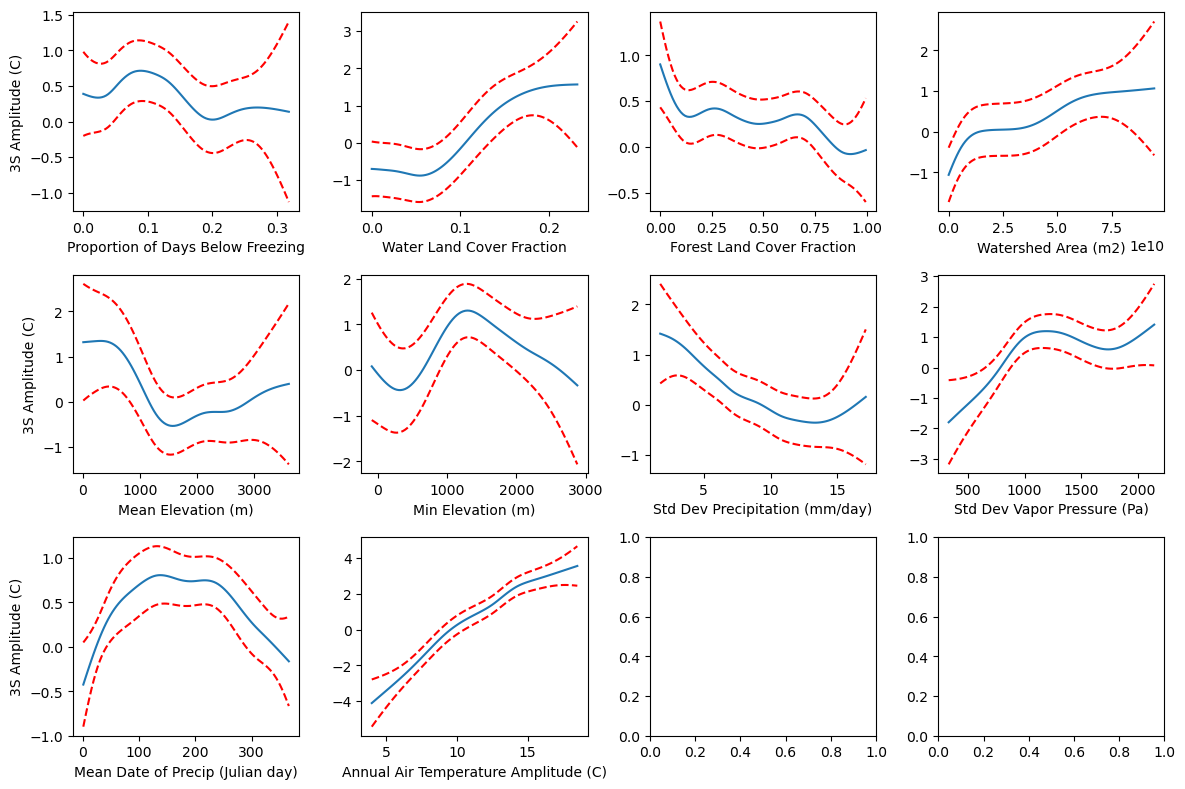

In [26]:
pdps(gam_amp, False, rename(var_amp),
     "3S Amplitude (C)", "results/PDPs/AmplitudeGAM.png")

## SpringSummer

In [35]:
var_ssu = ['intercept', 'prcp', 'cold_prcp', 'frozen',
       'water', 'elev', 'elev_min',
       'prcp_sd', 'srad_sd', 'vp']
eq_ssu = sum([s(i) for i in range(1, len(var_ssu))], start=s(0))
lam_ssu = 10
gam_ssu = LinearGAM(eq_ssu, lam=lam_ssu).fit(pds[var_ssu], pds["SpringSummer"])
gam_ssu.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     62.4147
Link Function:                     IdentityLink Log Likelihood:                                 -1065.2686
Number of Samples:                          921 AIC:                                             2257.3666
                                                AICc:                                            2266.9041
                                                GCV:                                                0.5071
                                                Scale:                                              0.4456
                                                Pseudo R-Squared:                                   0.5442
Feature Function                  Lam

/tmp/ipykernel_3401160/301628268.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_ssu.summary()


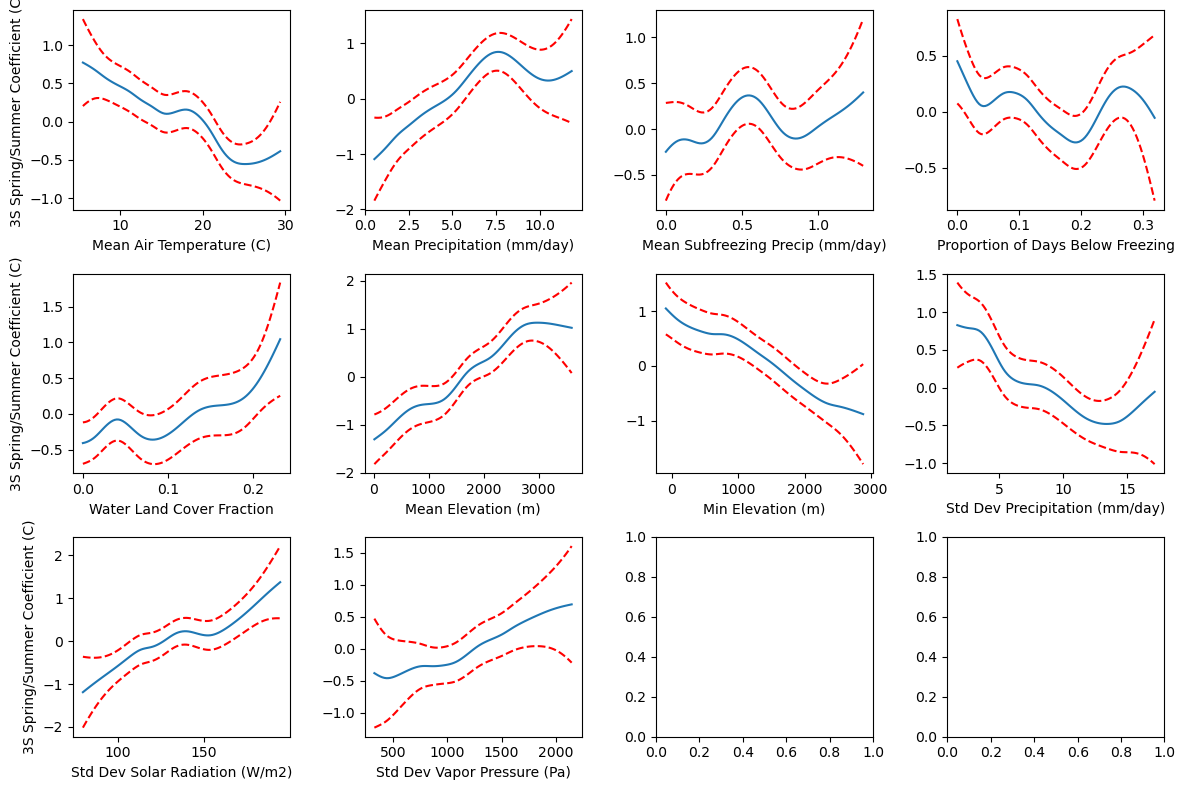

In [55]:
pdps(gam_ssu, False, rename(var_ssu), "3S Spring/Summer Coefficient (C)", "results/PDPs/SpringSummerGAM.png")

## FallWinter

In [44]:
var_fw = ['intercept', 'frozen', 'srad',
       'water', 'forest', 'elev',
       'slope', 'lat', 'lon',
       'vp', 'ssn_index', 'tamp']
eq_fw = sum([s(i) for i in range(1, len(var_fw))], start=s(0))
lam_fw = 10
gam_fw = LinearGAM(eq_fw, lam=lam_fw).fit(pds[var_fw], pds["FallWinter"])
gam_fw.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     76.9758
Link Function:                     IdentityLink Log Likelihood:                                 -1048.6481
Number of Samples:                          921 AIC:                                              2253.248
                                                AICc:                                            2267.8751
                                                GCV:                                                0.5316
                                                Scale:                                              0.4523
                                                Pseudo R-Squared:                                   0.5101
Feature Function                  Lam

/tmp/ipykernel_3401160/2698865326.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_fw.summary()


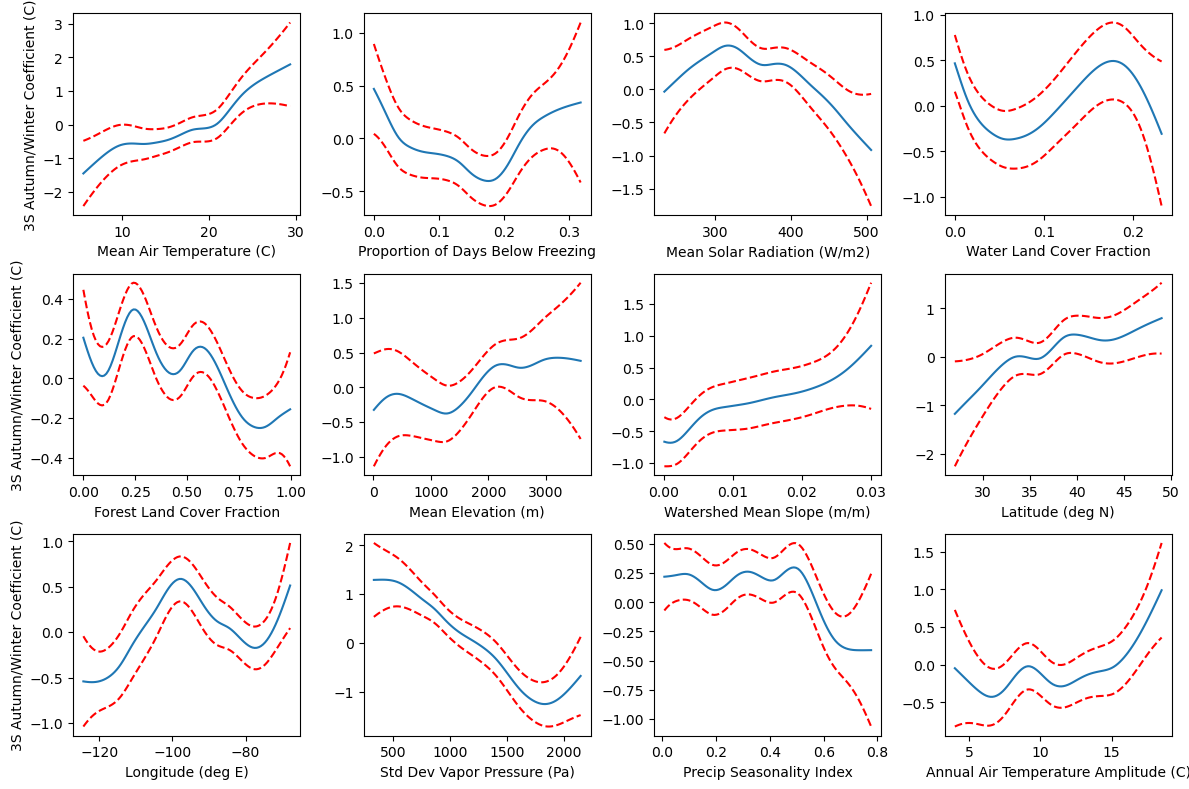

In [45]:
pdps(gam_fw, False, rename(var_fw),
     "3S Autumn/Winter Coefficient (C)", "results/PDPs/FallWinterGAM.png")

## SpringDay

In [51]:
var_spd = ['intercept', 'elev',
       'lat', 'lon',
       'ssn_phi', 'ssn_index', 'tamp', 'canopy']
eq_spd = sum([s(i) for i in range(1, len(var_spd))], start=s(0))
lam_spd = 10
gam_spd = LinearGAM(eq_spd, lam=lam_spd).fit(pds[var_spd], pds["SpringDay"])
gam_spd.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     56.3883
Link Function:                     IdentityLink Log Likelihood:                                 -6141.9732
Number of Samples:                          921 AIC:                                            12398.7229
                                                AICc:                                           12406.4919
                                                GCV:                                               352.278
                                                Scale:                                            313.6803
                                                Pseudo R-Squared:                                   0.3706
Feature Function                  Lam

/tmp/ipykernel_3401160/2609277983.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_spd.summary()


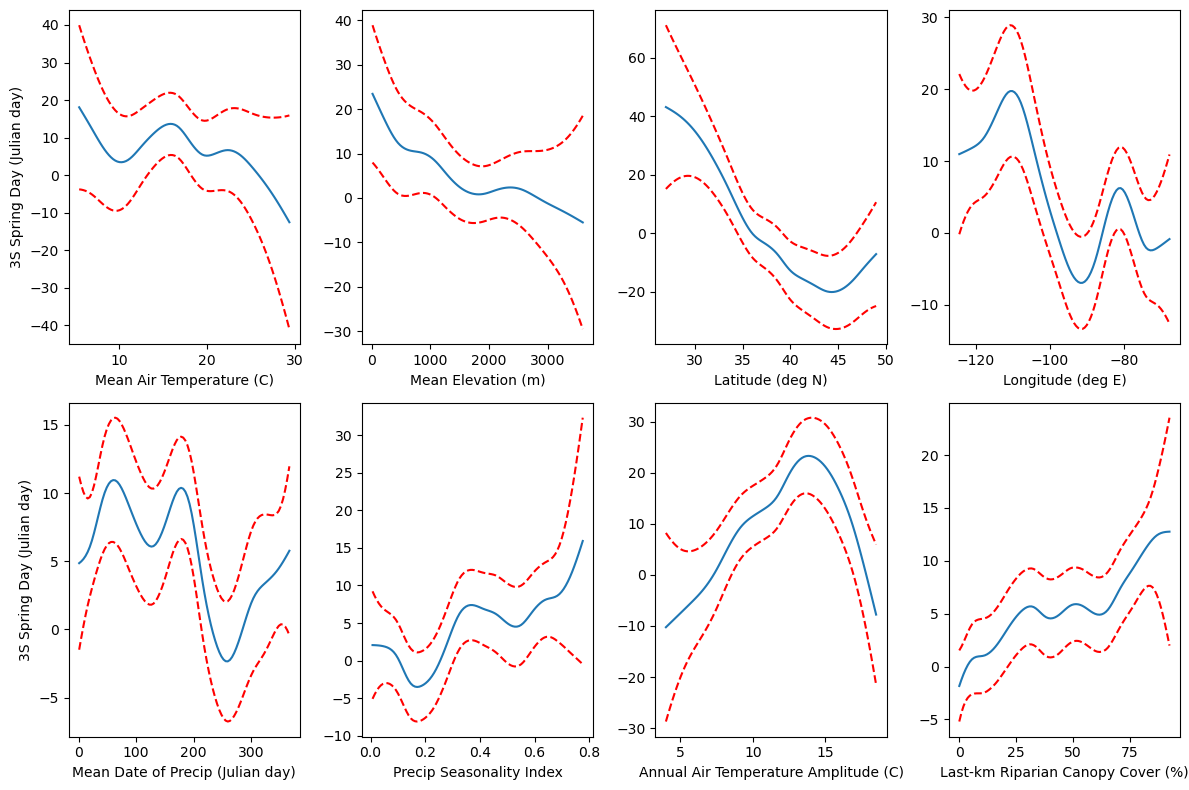

In [54]:
pdps(gam_spd, False, rename(var_spd), "3S Spring Day (Julian day)", "results/PDPs/SpringDayGAM.png")

## SummerDay

In [65]:
var_sud = ['prcp', 'cold_prcp', 'frozen',
       'wetland', 'ice_snow', 'elev',
       'lat', 'lon', 'prcp_sd','ssn_index', 'canopy']
eq_sud = sum([s(i) for i in range(1, len(var_sud))], start=s(0))
lam_sud = 10
gam_sud = LinearGAM(eq_sud, lam=lam_sud).fit(pds[var_sud], pds["SummerDay"])
gam_sud.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     69.7202
Link Function:                     IdentityLink Log Likelihood:                                 -5852.9002
Number of Samples:                          921 AIC:                                            11847.2407
                                                AICc:                                           11859.1851
                                                GCV:                                              264.8917
                                                Scale:                                            229.0601
                                                Pseudo R-Squared:                                   0.2936
Feature Function                  Lam

/tmp/ipykernel_3401160/1563471385.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_sud.summary()


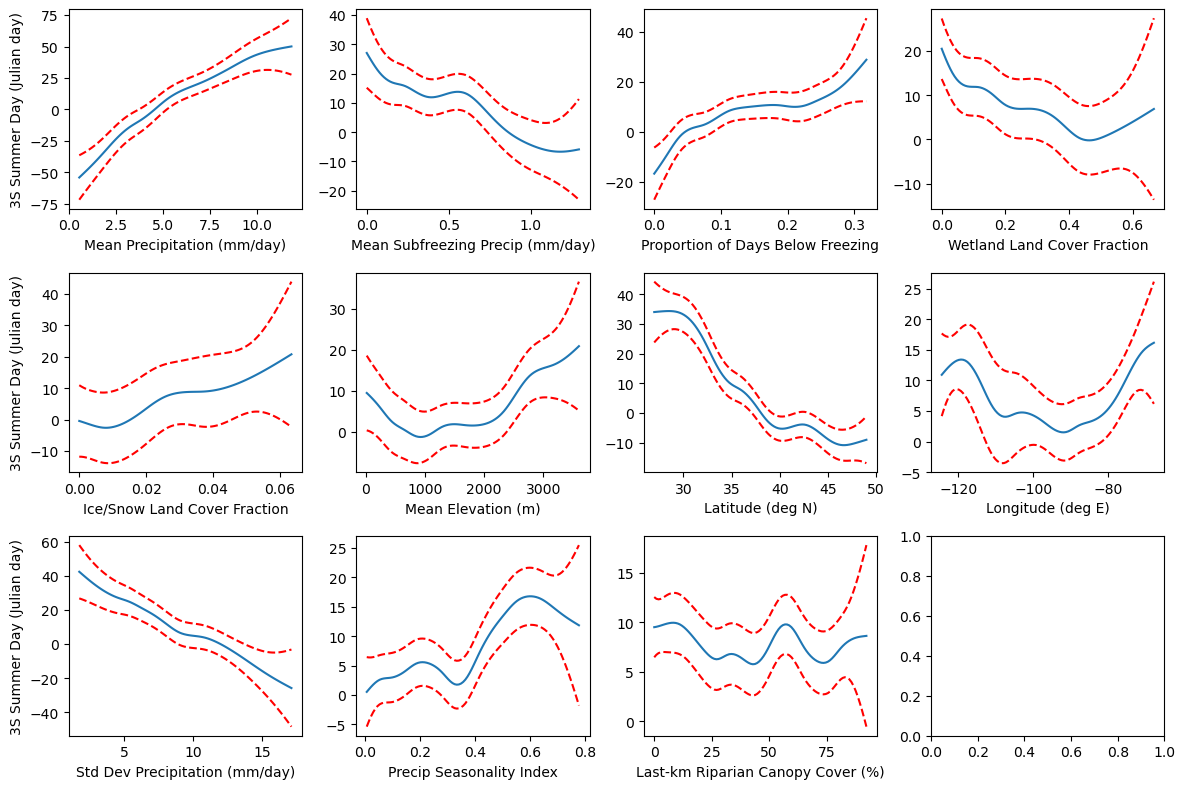

In [66]:
pdps(gam_sud, False, rename(var_sud), "3S Summer Day (Julian day)", "results/PDPs/SummerDayGAM.png")

## FallDay

In [72]:
var_fad = ['srad',
       'water', 'developed', 'forest',
       'wetland', 'ice_snow', 'elev_min',
       'lat', 'lon', 'flowdir']
eq_fad = sum([s(i) for i in range(1, len(var_fad))], start=s(0))
lam_fad = 10
gam_fad = LinearGAM(eq_fad, lam=lam_fad).fit(pds[var_fad], pds["FallDay"])
gam_fad.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.9669
Link Function:                     IdentityLink Log Likelihood:                                 -5541.7045
Number of Samples:                          921 AIC:                                            11213.3428
                                                AICc:                                           11223.3673
                                                GCV:                                              186.3946
                                                Scale:                                            163.2468
                                                Pseudo R-Squared:                                   0.3756
Feature Function                  Lam

/tmp/ipykernel_3401160/606214756.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_fad.summary()


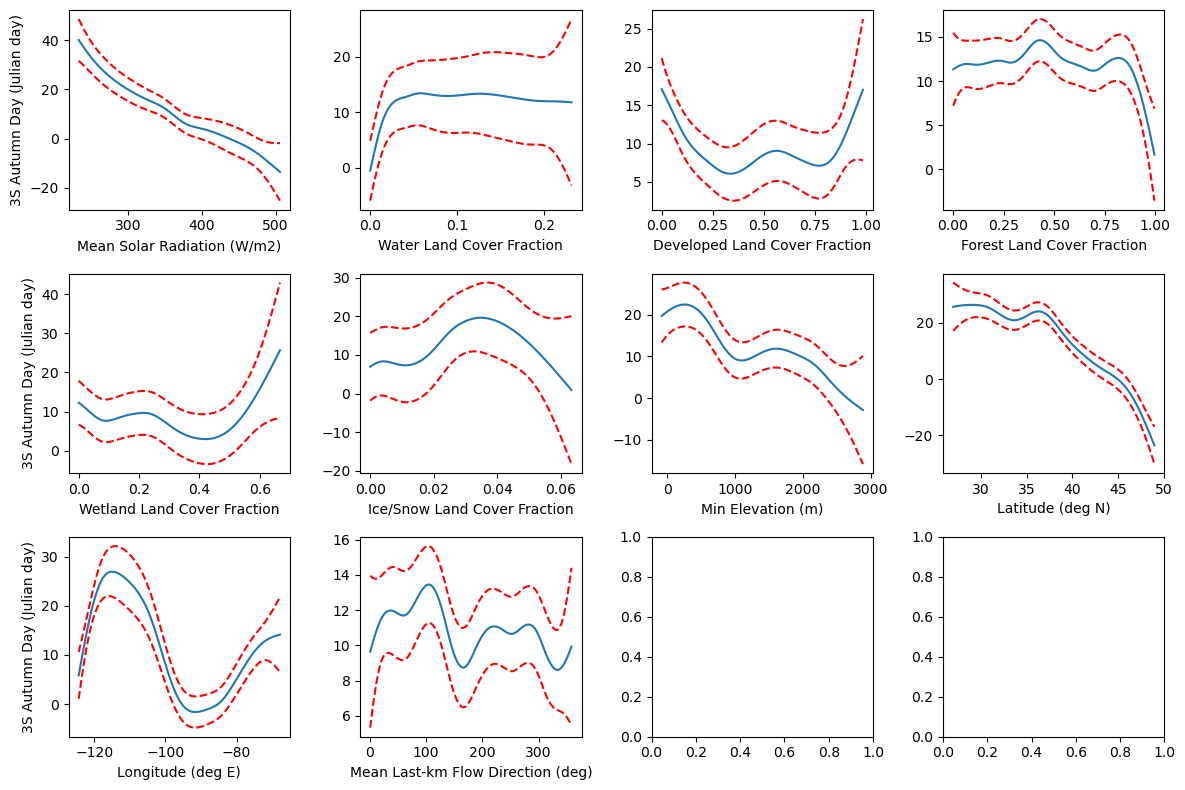

In [70]:
pdps(gam_fad, False, rename(var_fad),
     "3S Autumn Day (Julian day)", "results/PDPs/FallDayGAM.png")

## WinterDay

In [76]:
var_wid = ['frozen', 'water', 'forest', 'wetland', 'srad_sd', 'tamp']
eq_wid = sum([s(i) for i in range(len(var_wid))], start=s(0))
lam_wid = 10
gam_wid = LinearGAM(eq_wid, lam=lam_wid).fit(pds[var_wid], pds["WinterDay"])
gam_wid.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     39.5605
Link Function:                     IdentityLink Log Likelihood:                                 -6761.4193
Number of Samples:                          921 AIC:                                            13603.9596
                                                AICc:                                           13607.7932
                                                GCV:                                               666.345
                                                Scale:                                            615.0309
                                                Pseudo R-Squared:                                   0.4412
Feature Function                  Lam

/tmp/ipykernel_3401160/908341900.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_wid.summary()


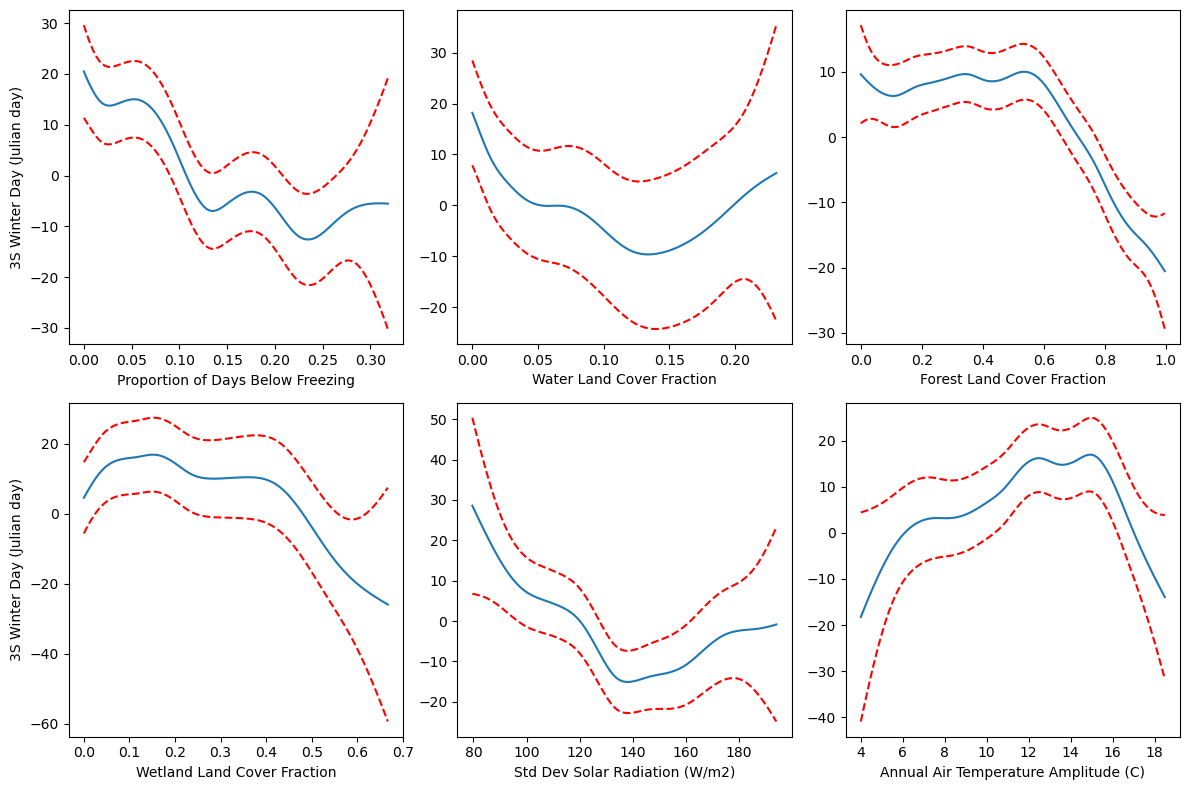

In [77]:
pdps(gam_wid, False, rename(var_wid),
    "3S Winter Day (Julian day)", "results/PDPs/WinterDayGAM.png")

## Max Sensitivity

intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.

In [81]:
# intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.
# var_tcmax = ["Intercept", "Amplitude", "intercept", "atmax", "water", "vp"]
var_tcmax = ["Intercept", 'intercept', 'frozen', 'srad',
       'water', 'area',
       'lat', 'lon', 'ssn_index']
eq_tcmax = sum([s(i) for i in range(1, len(var_tcmax))], start=s(0))
lam_tcmax = 10
gam_tcmax = LinearGAM(eq_tcmax, lam=lam_tcmax).fit(pds[var_tcmax], pds["threshold_coef_max"])
gam_tcmax.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     57.8896
Link Function:                     IdentityLink Log Likelihood:                                -12596.8094
Number of Samples:                          921 AIC:                                             25311.398
                                                AICc:                                           25319.5895
                                                GCV:                                                0.0324
                                                Scale:                                              0.0287
                                                Pseudo R-Squared:                                   0.5274
Feature Function                  Lam

/tmp/ipykernel_3401160/1650920775.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_tcmax.summary()


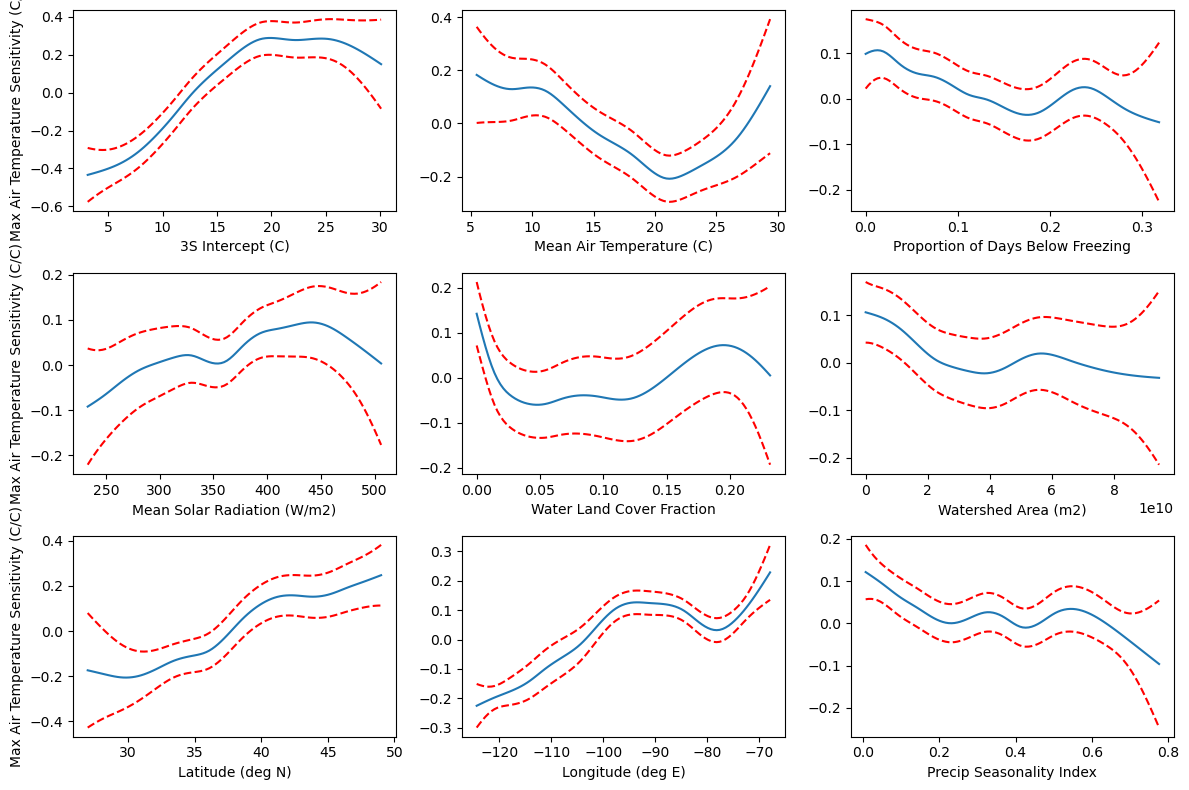

In [82]:
pdps(gam_tcmax, False, rename(var_tcmax),
    "Max Air Temperature Sensitivity (C/C)", "results/PDPs/TCMaxGAM.png")

## Min Sensitivity

In [87]:
# intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.
# var_tcmin = ["atmin", "srad_sd", "vp", "ssn_index"]
var_tcmin = ['intercept', 'frozen', 'srad',
       'elev', 'tamp']
eq_tcmin = sum([s(i) for i in range(1, len(var_tcmin))], s(0))
lam_tcmin = 10
gam_tcmin = LinearGAM(eq_tcmin, lam=lam_tcmin).fit(pds[pds["threshold_coef_min"] > -1][var_tcmin], pds[pds["threshold_coef_min"] > -1]["threshold_coef_min"])
gam_tcmin.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     32.0113
Link Function:                     IdentityLink Log Likelihood:                                -17126.4787
Number of Samples:                          610 AIC:                                              34318.98
                                                AICc:                                           34322.8786
                                                GCV:                                                0.0167
                                                Scale:                                              0.0151
                                                Pseudo R-Squared:                                   0.6373
Feature Function                  Lam

/tmp/ipykernel_3401160/2460864100.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_tcmin.summary()


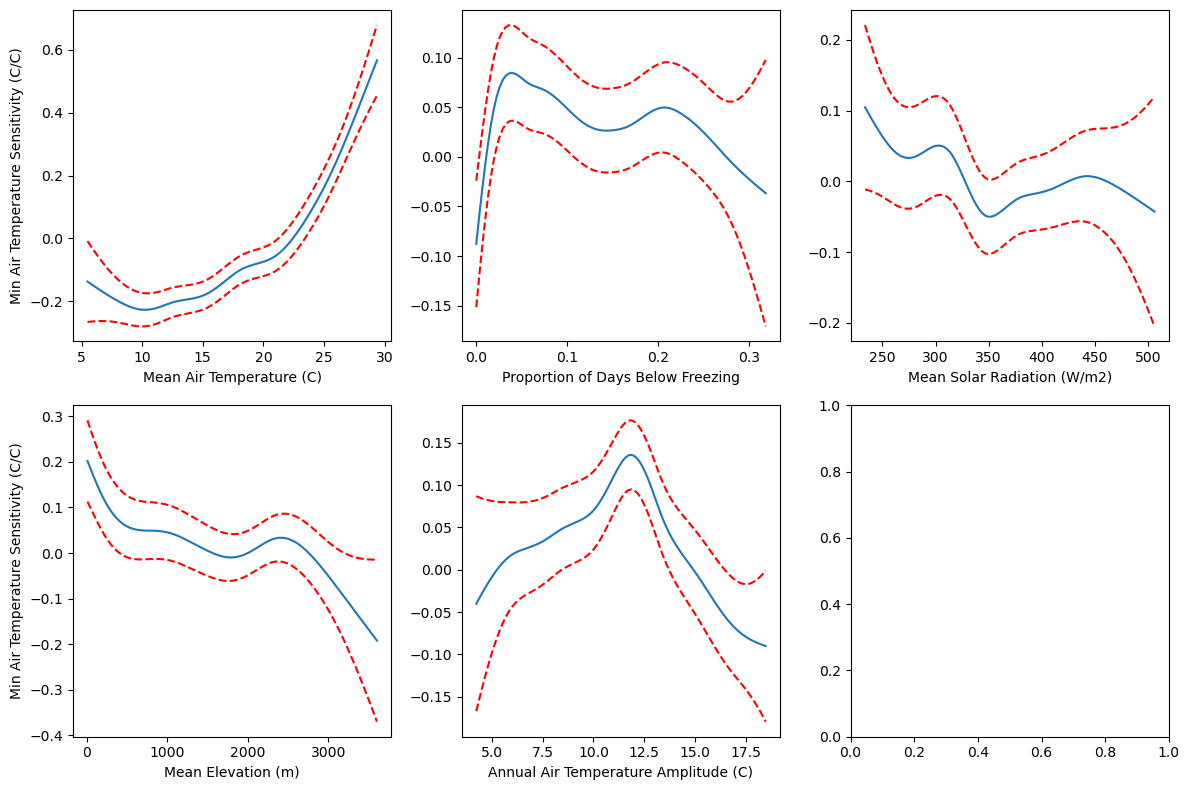

In [88]:
pdps(gam_tcmin, False, rename(var_tcmin),
    "Min Air Temperature Sensitivity (C/C)", "results/PDPs/TCMinGAM.png")

## Sensitivity Cutoff

In [97]:
# intercept, atmax, cold_prcp, frozen, water, developed, cultivated, wetland, elev_min, ssn_phi, ssn_index.
# var_tcc = ["frozen", "ssn_phi", "ssn_index", "vp", "srad_sd"]
var_tcc = ['frozen',
    'elev_min',
       'lat', 'lon', 'srad_sd', 'canopy', 'flowdir']
eq_tcc = sum([s(i) for i in range(1, len(var_tcc))], s(0))
lam_tcc = 10
gam_tcc = LinearGAM(eq_tcc, lam=lam_tcc).fit(pds[pds["threshold_coef_min"] > -1][var_tcc], pds[pds["threshold_coef_min"] > -1]["threshold_act_cutoff"])
gam_tcc.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     46.3261
Link Function:                     IdentityLink Log Likelihood:                                 -2538.8494
Number of Samples:                          610 AIC:                                              5172.351
                                                AICc:                                            5180.4948
                                                GCV:                                               29.0952
                                                Scale:                                             25.1469
                                                Pseudo R-Squared:                                   0.5186
Feature Function                  Lam

/tmp/ipykernel_3401160/3564920294.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_tcc.summary()


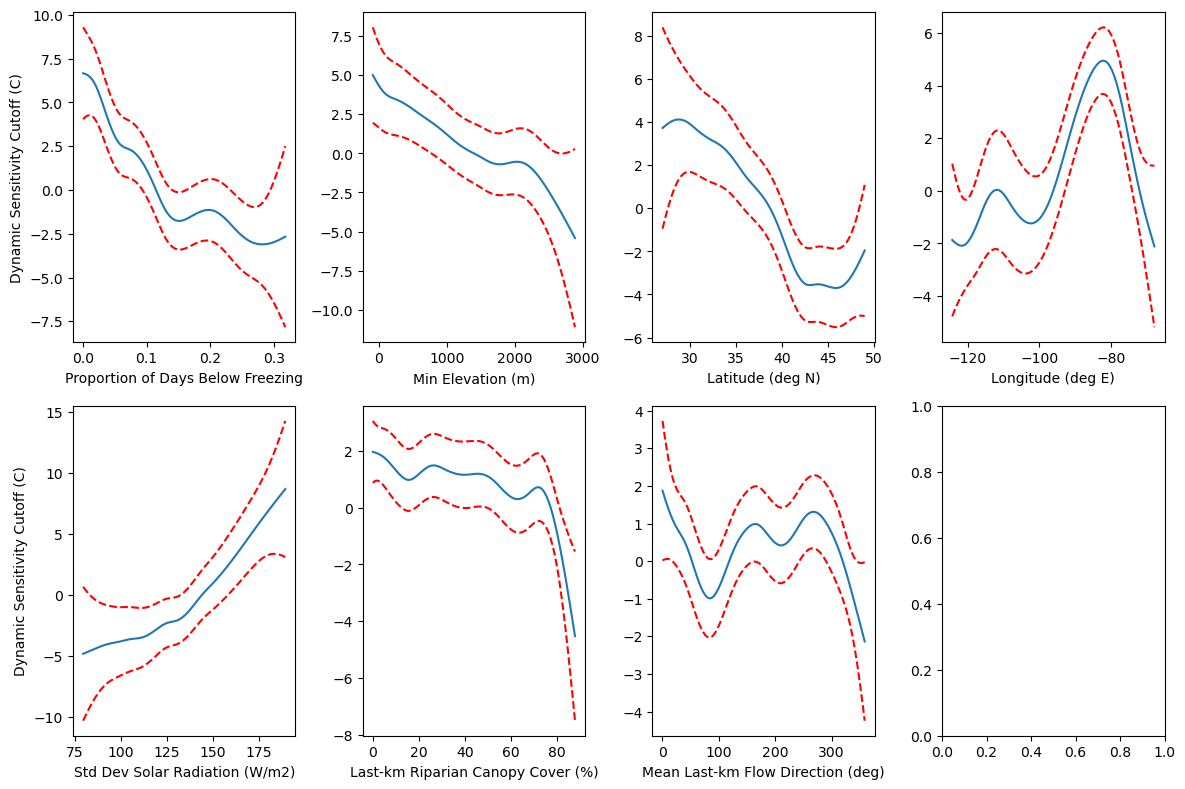

In [98]:
pdps(gam_tcc, False, rename(var_tcc),
     "Dynamic Sensitivity Cutoff (C)", "results/PDPs/TCCutoffGAM.png")

## Plot GAMs By XVar

/tmp/ipykernel_3401160/3694395137.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(nrow, ncol, figsize=(12, 8))


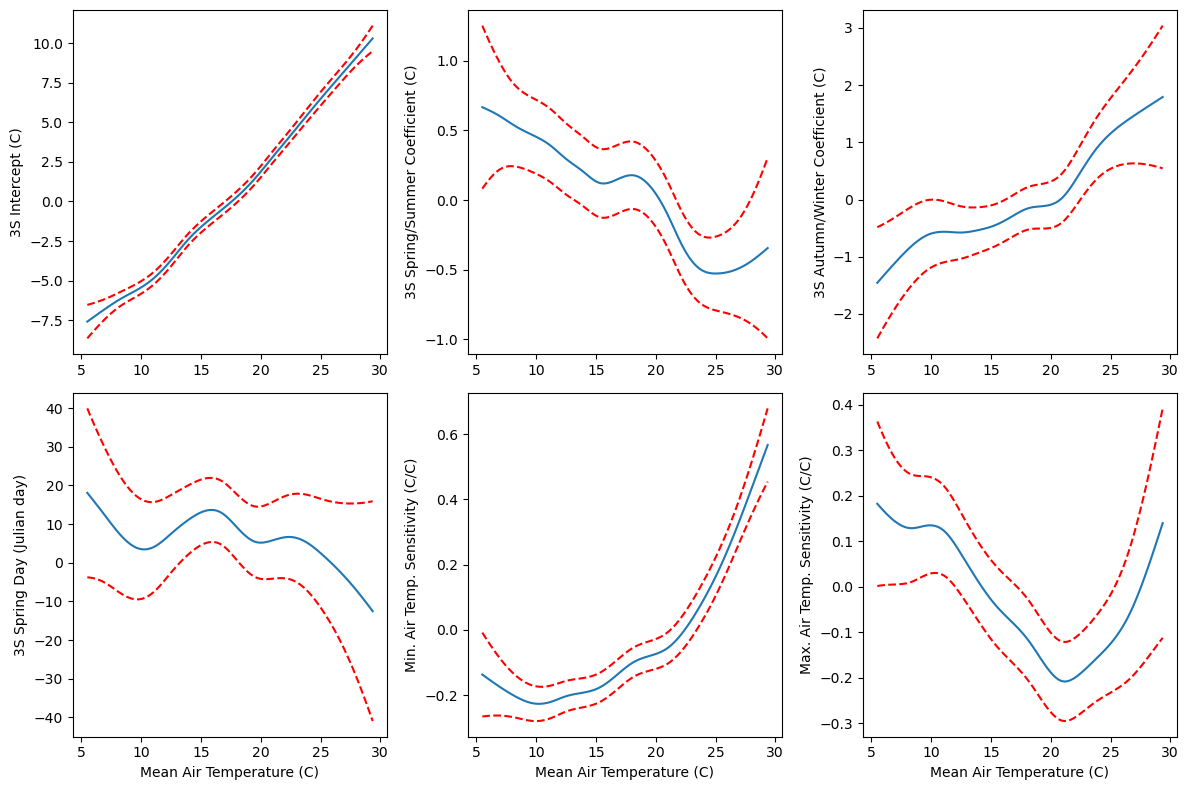

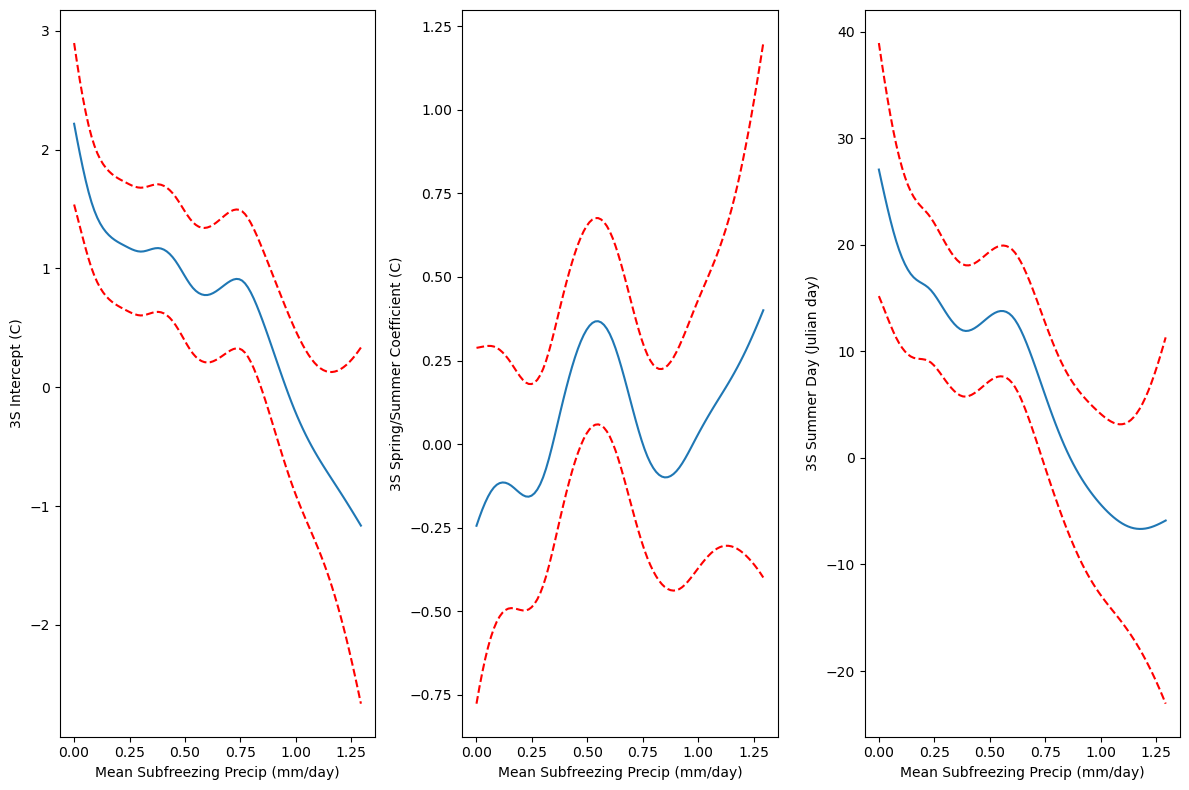

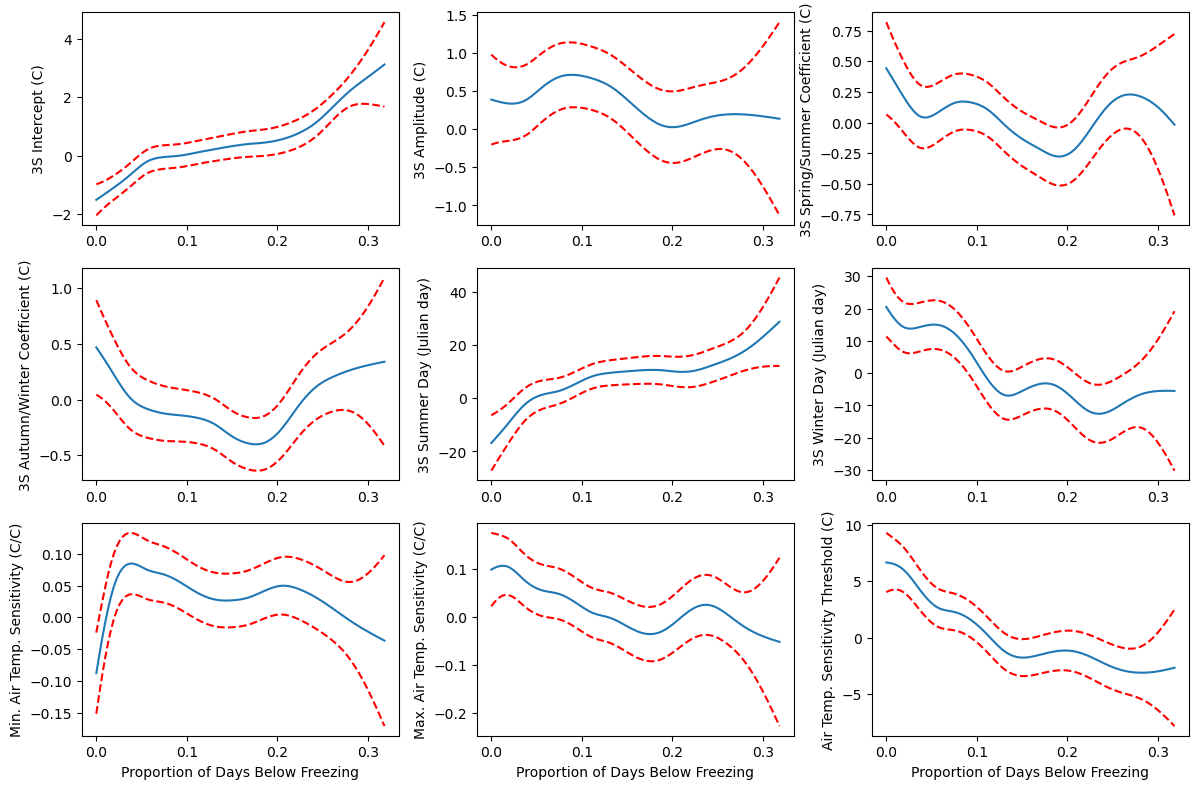

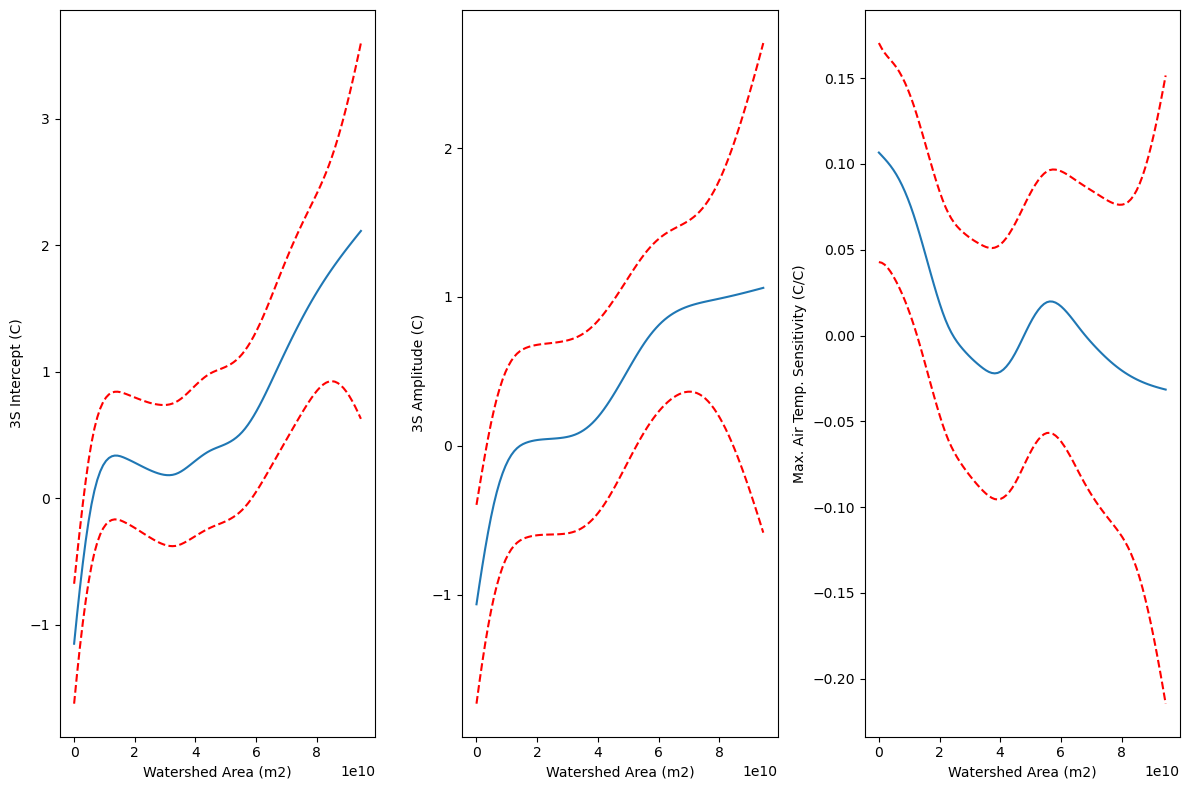

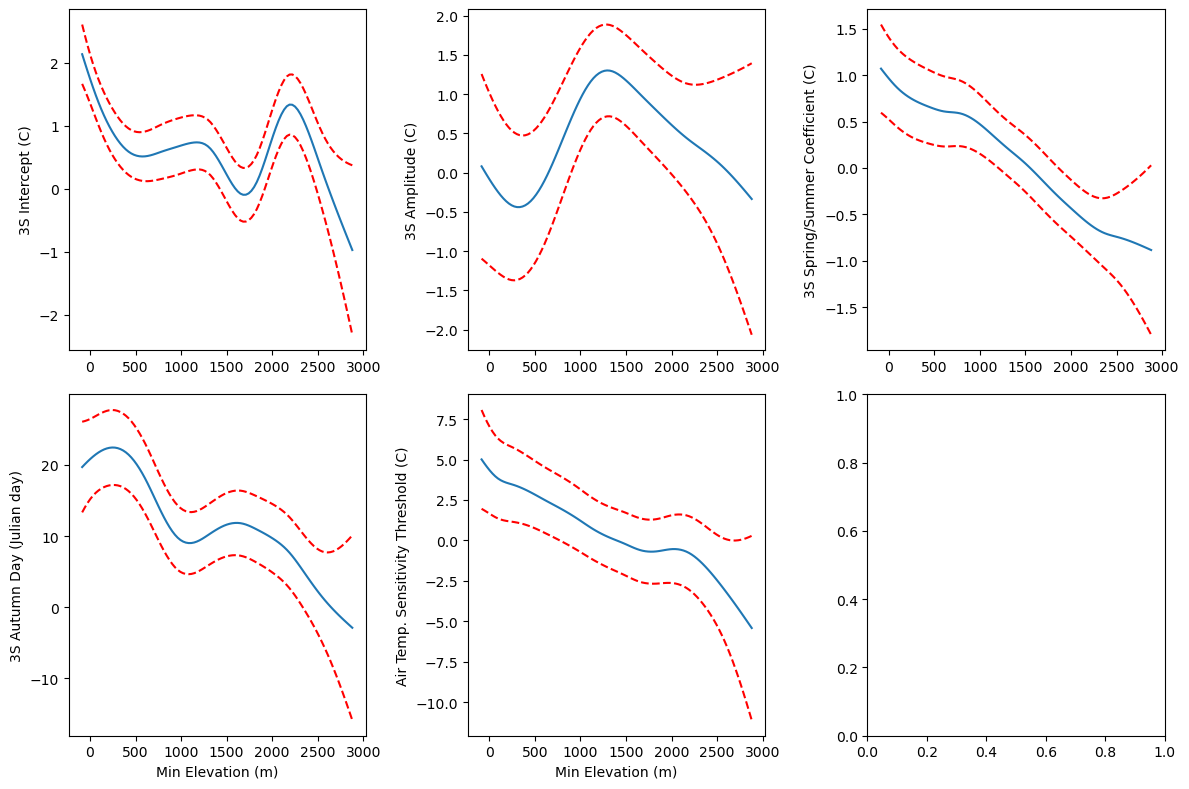

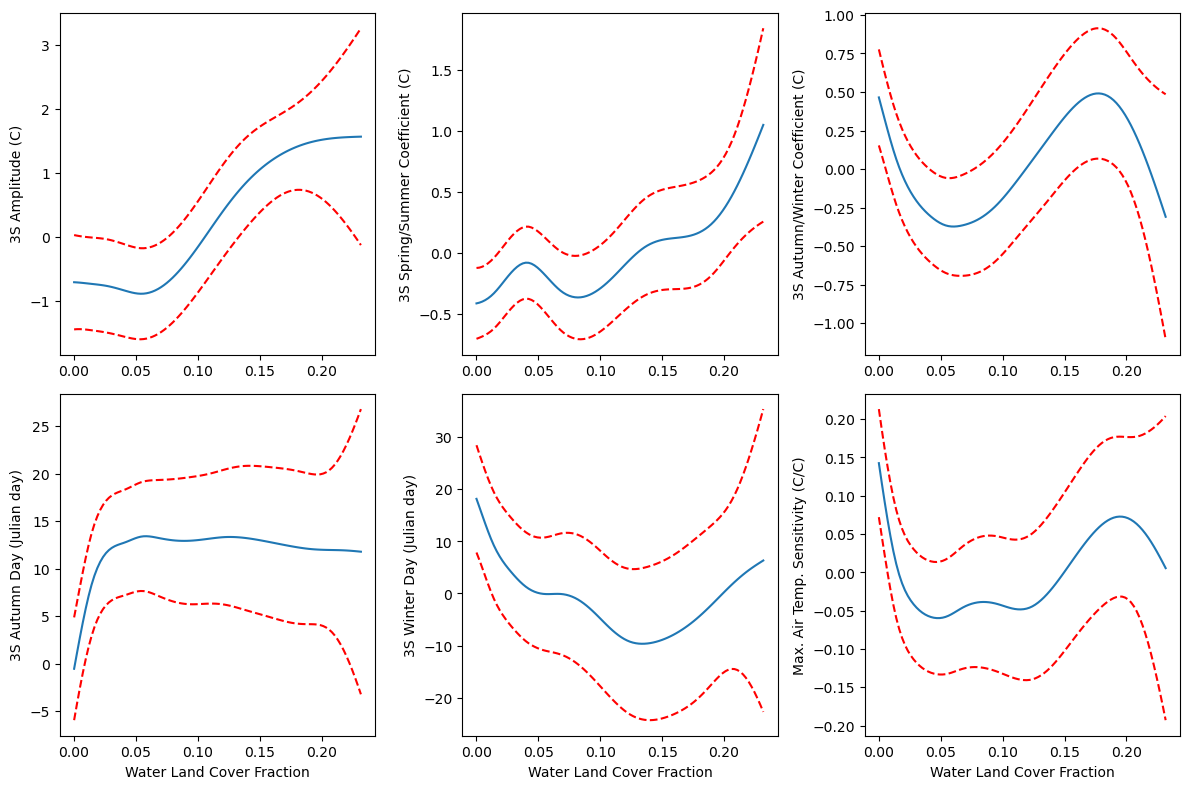

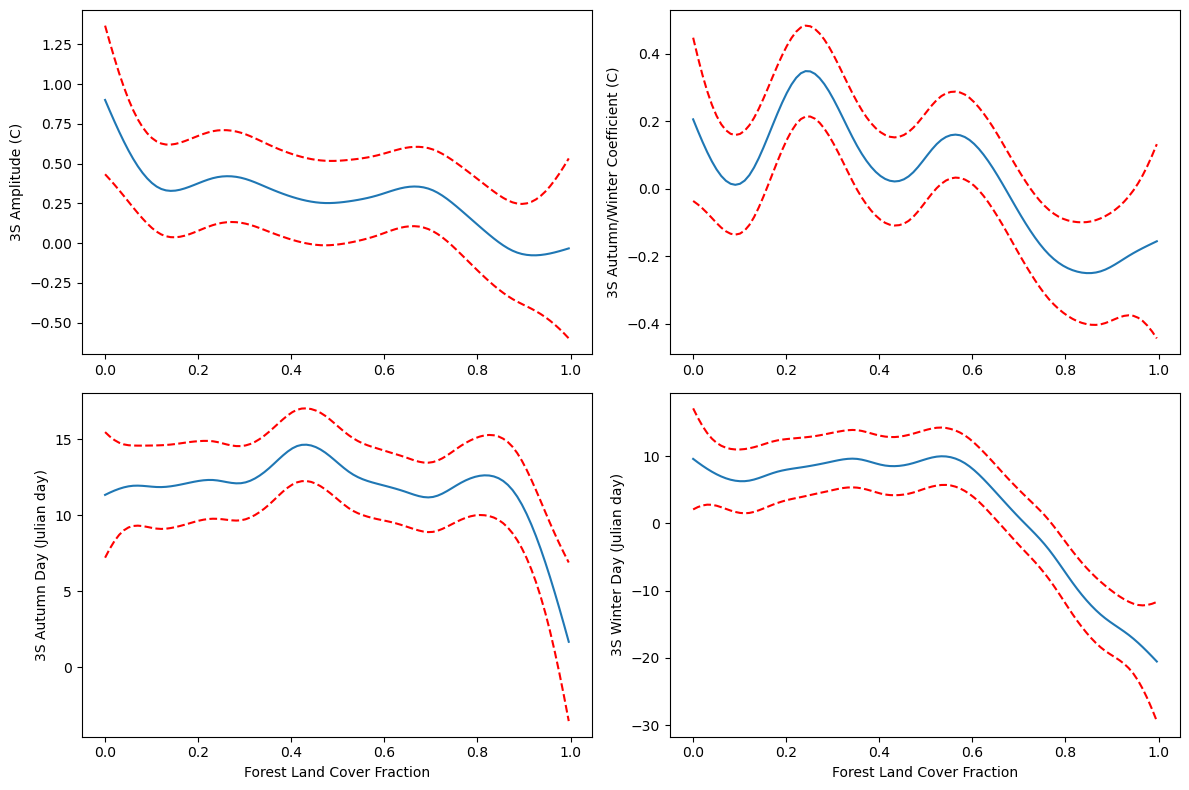

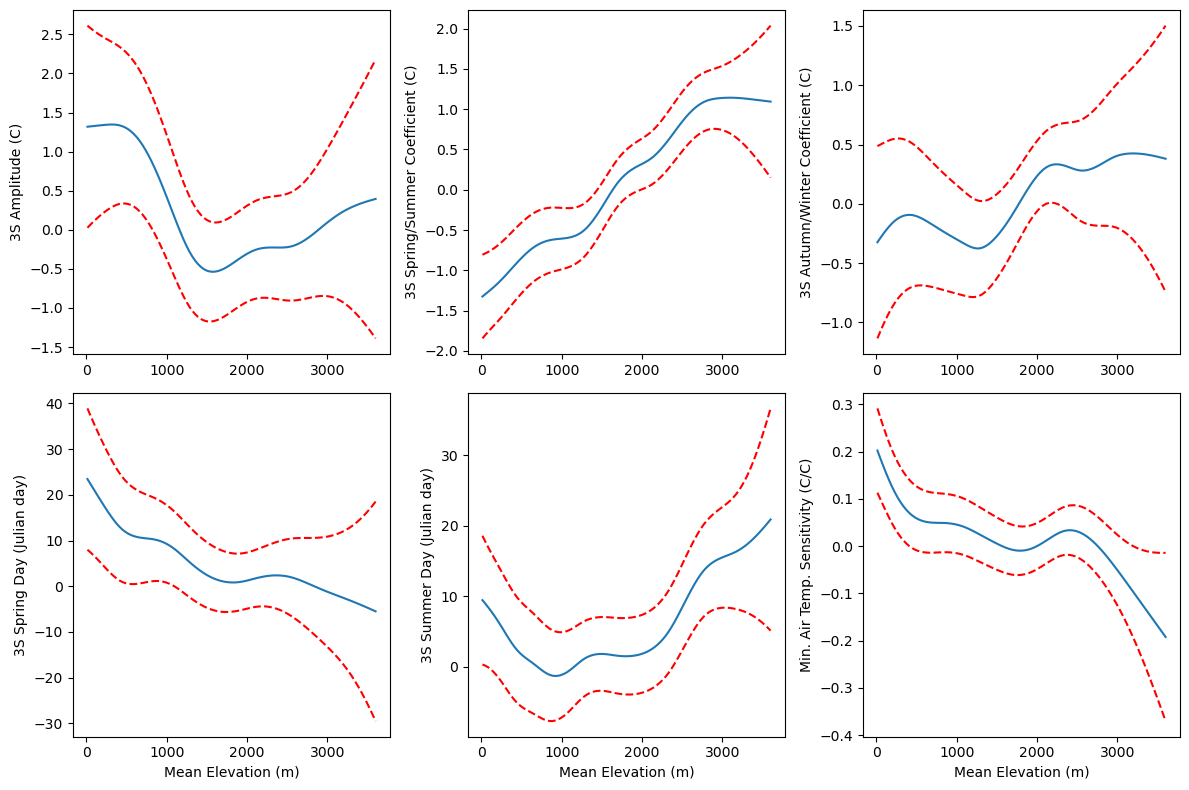

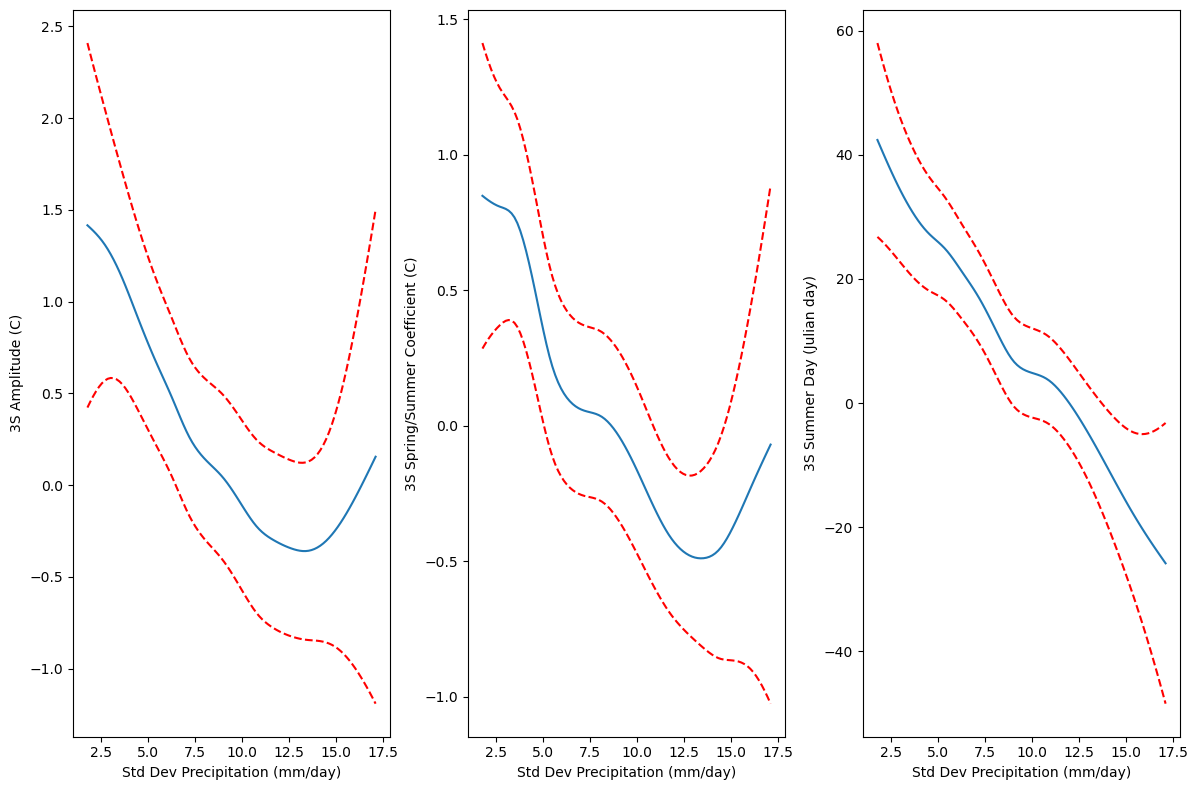

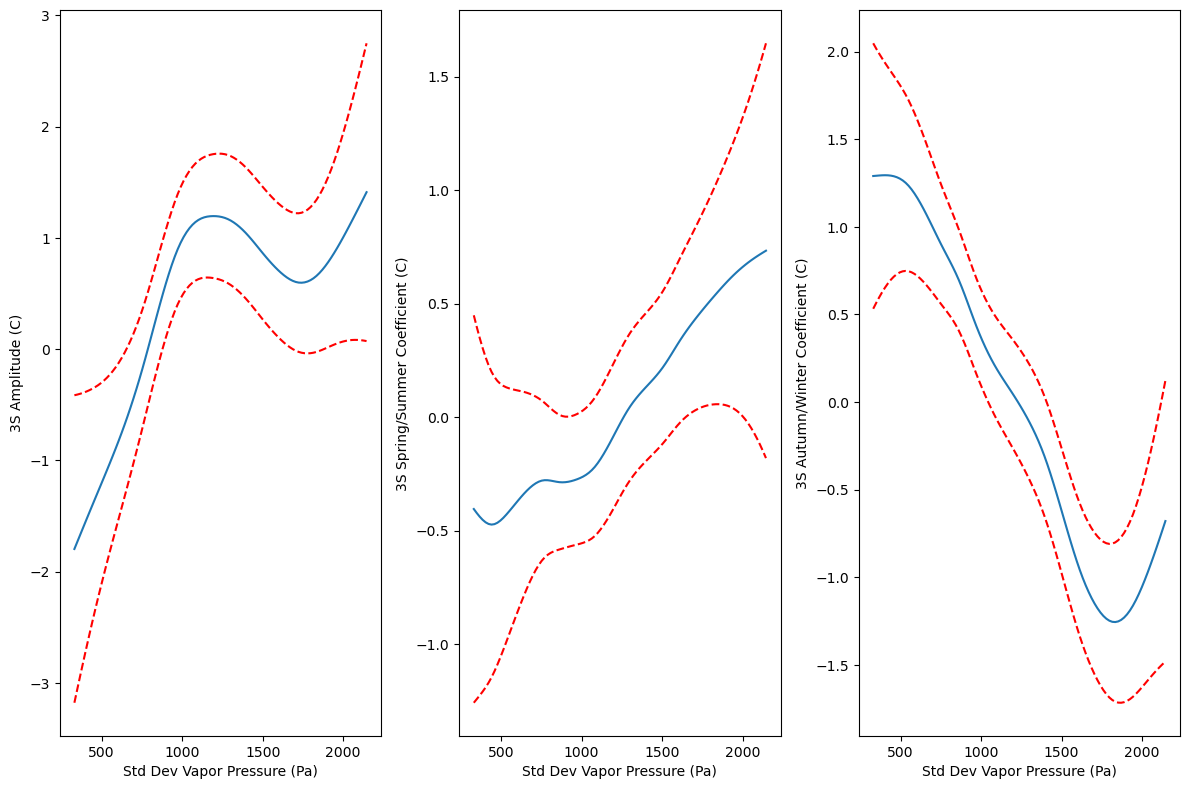

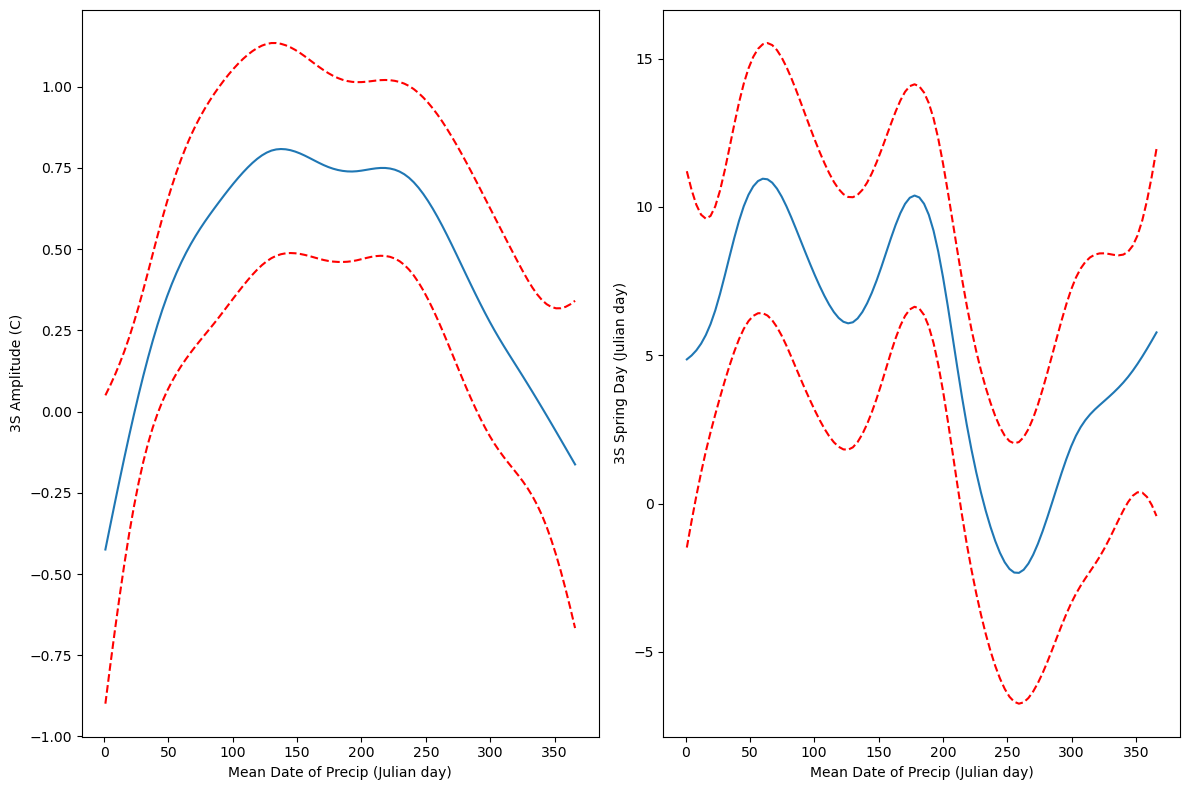

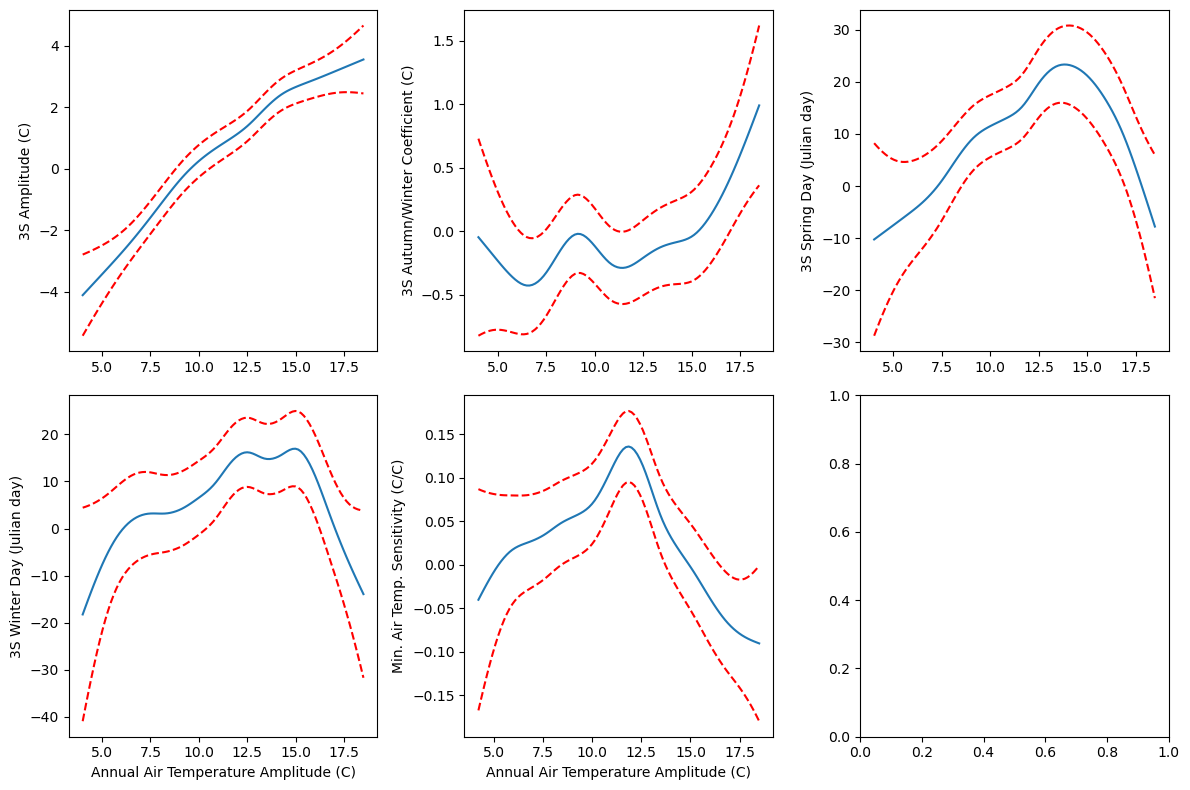

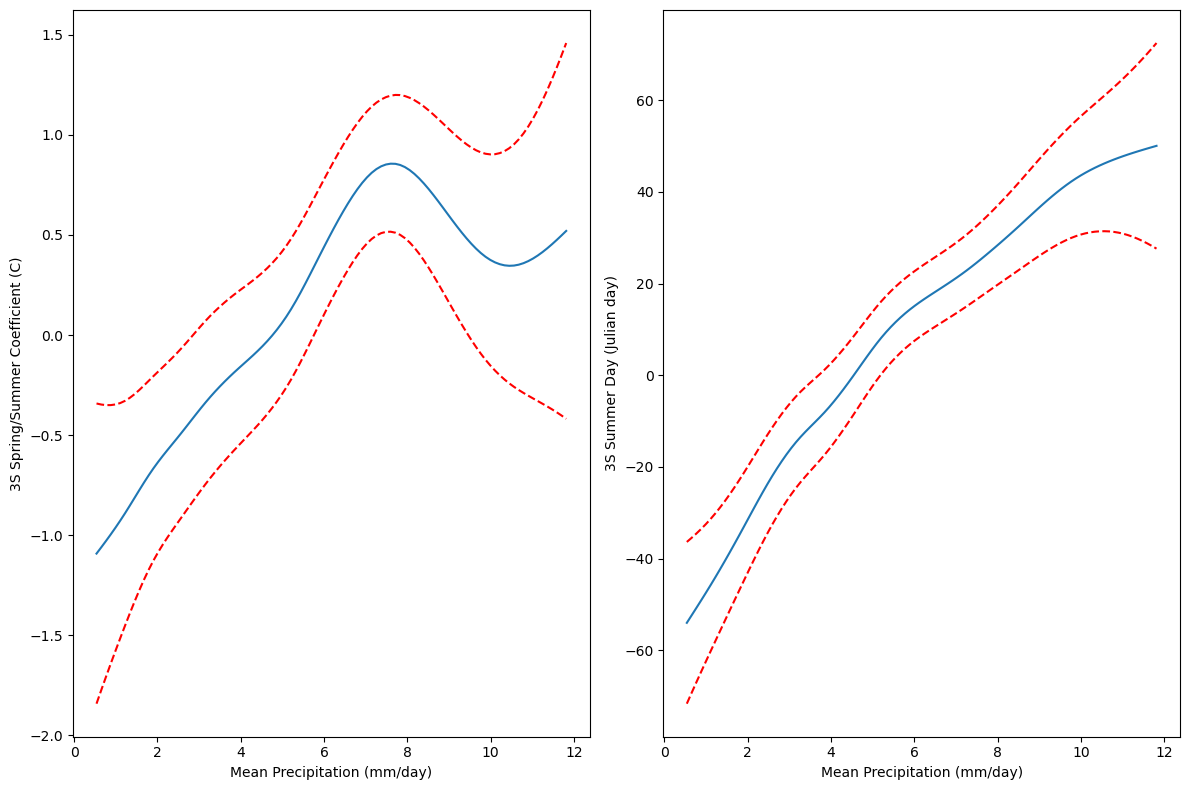

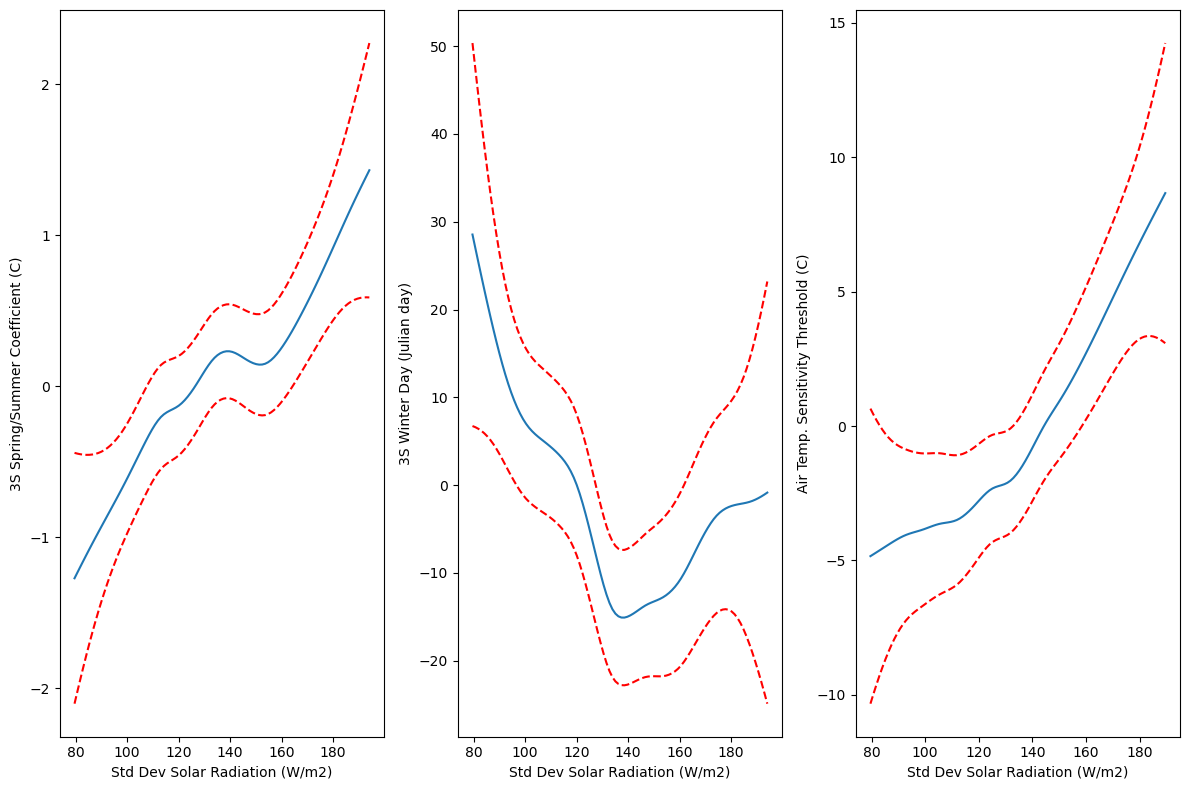

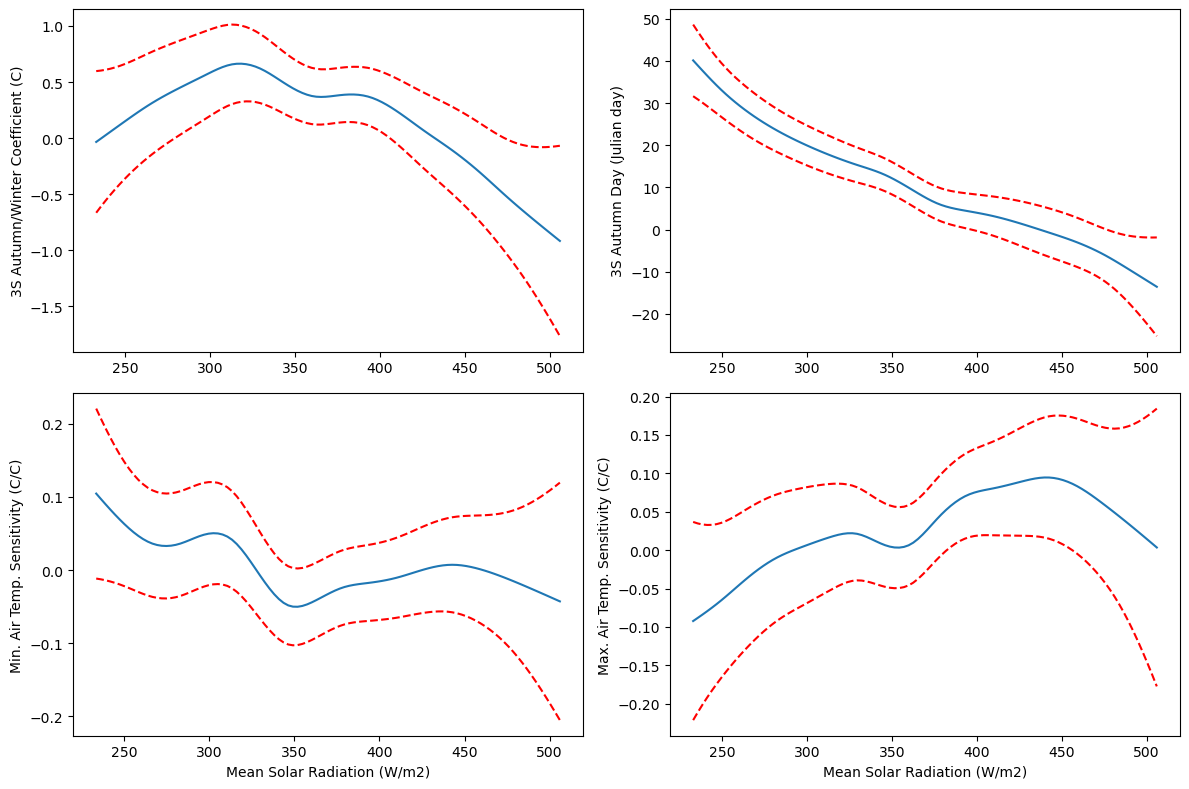

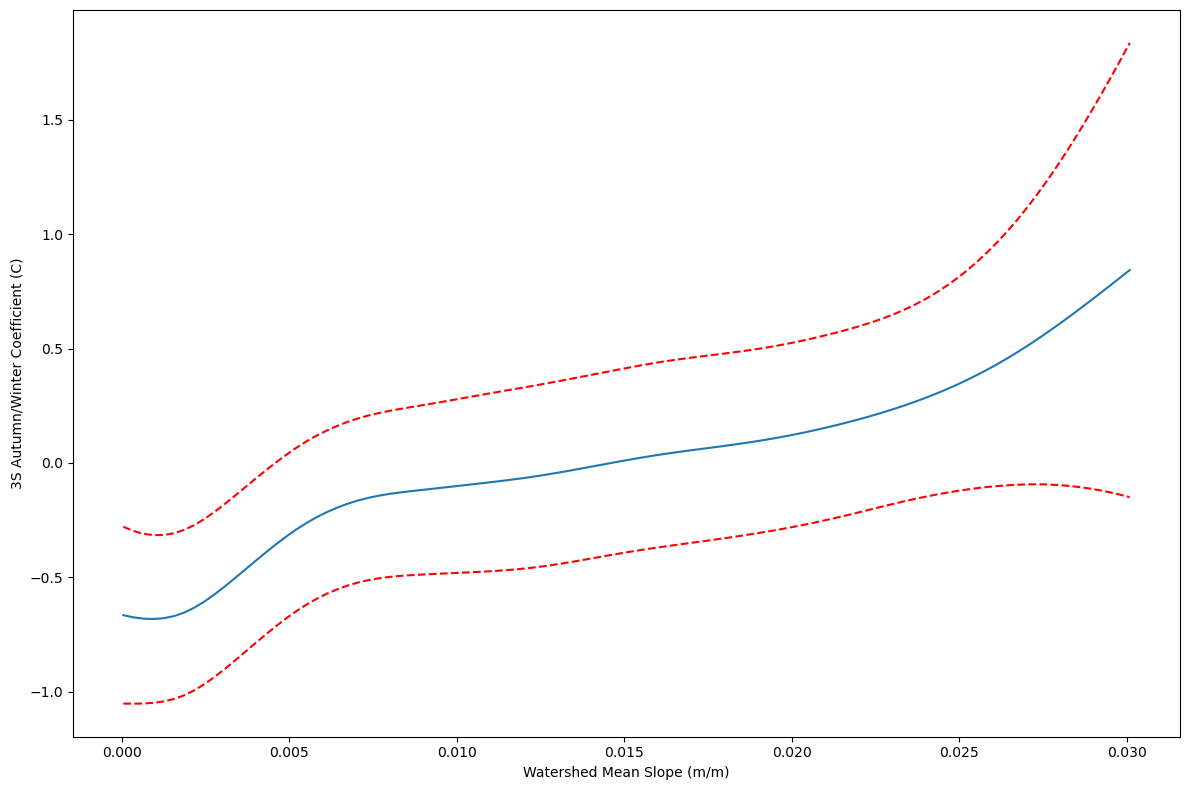

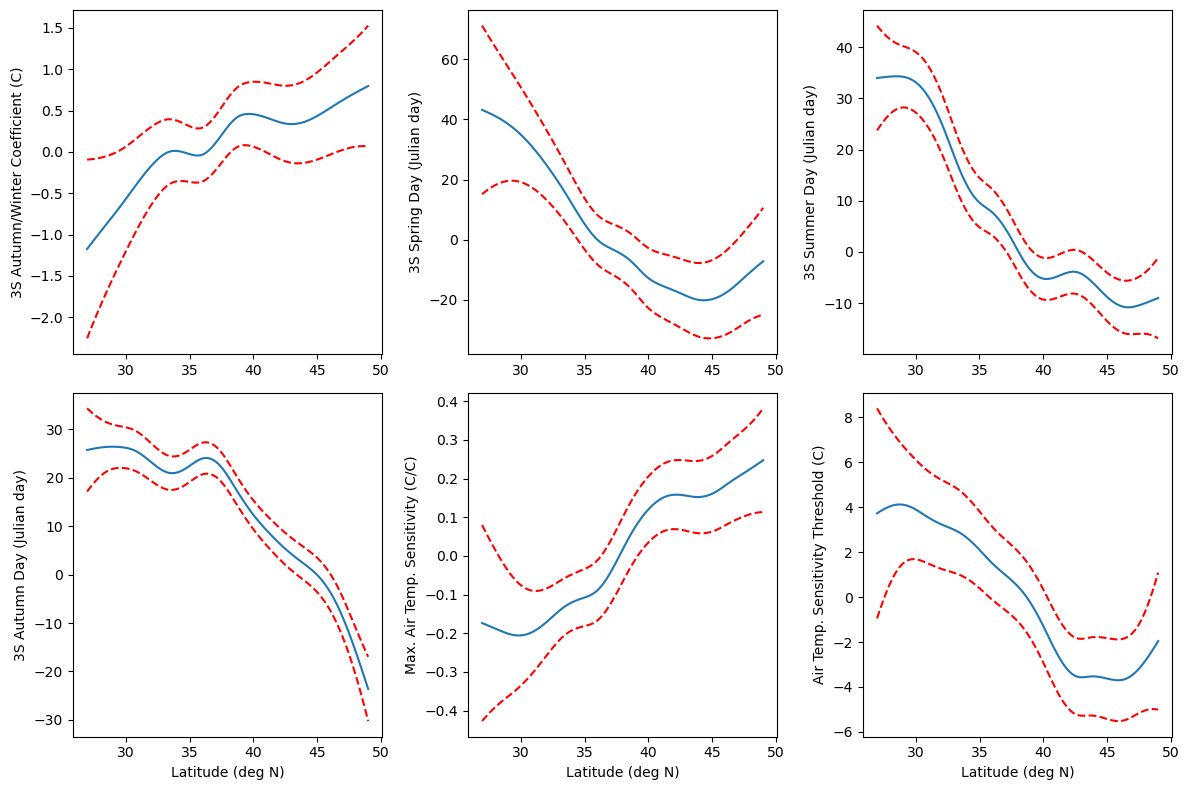

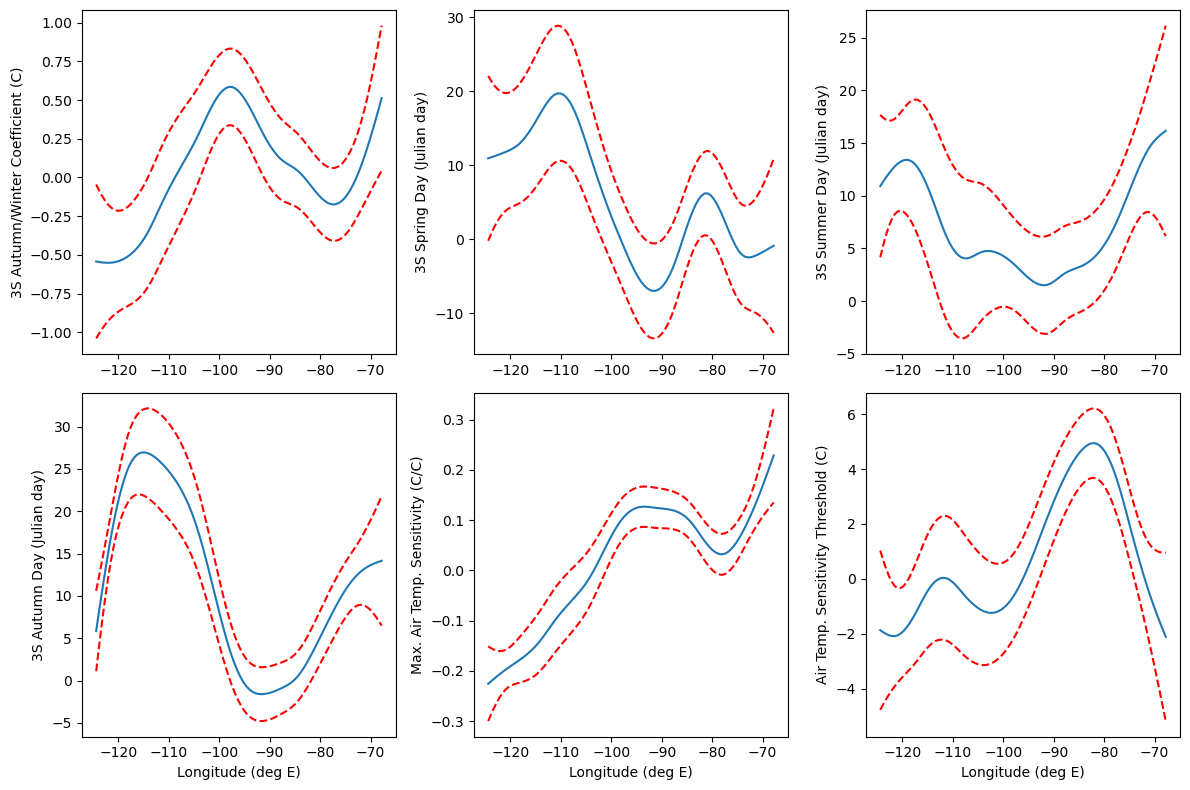

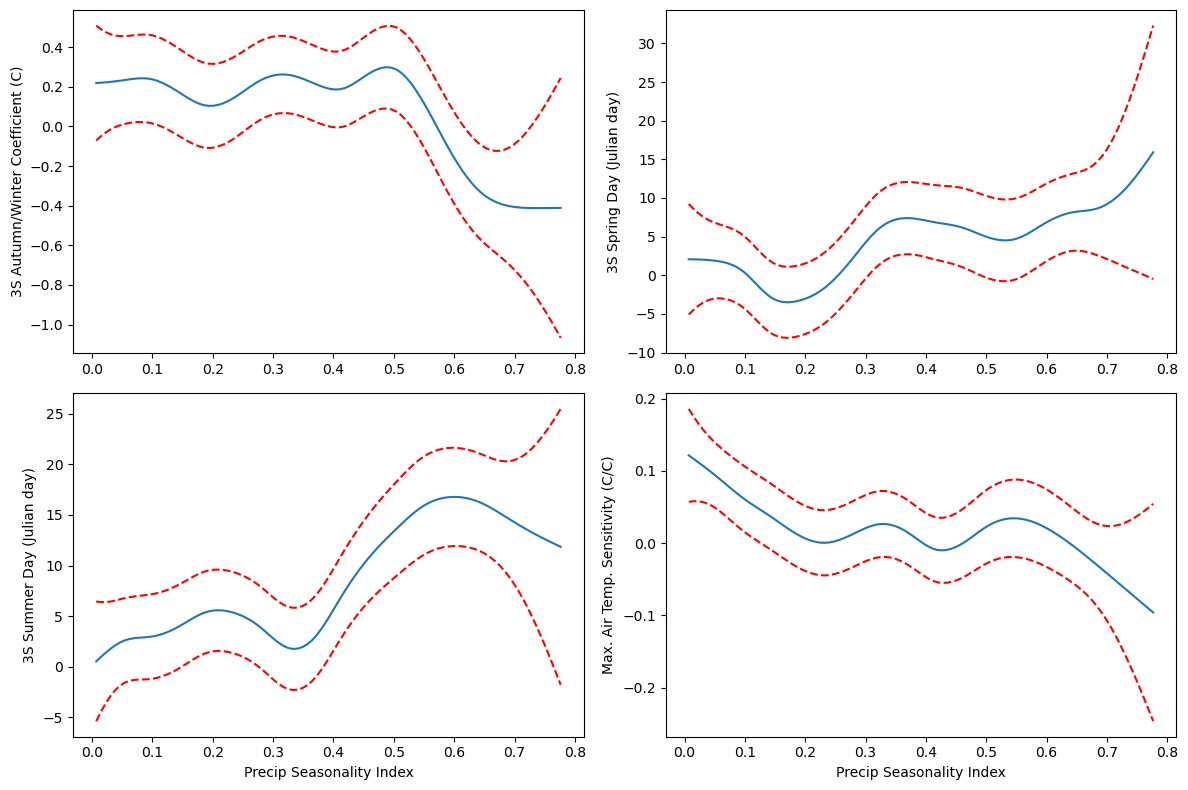

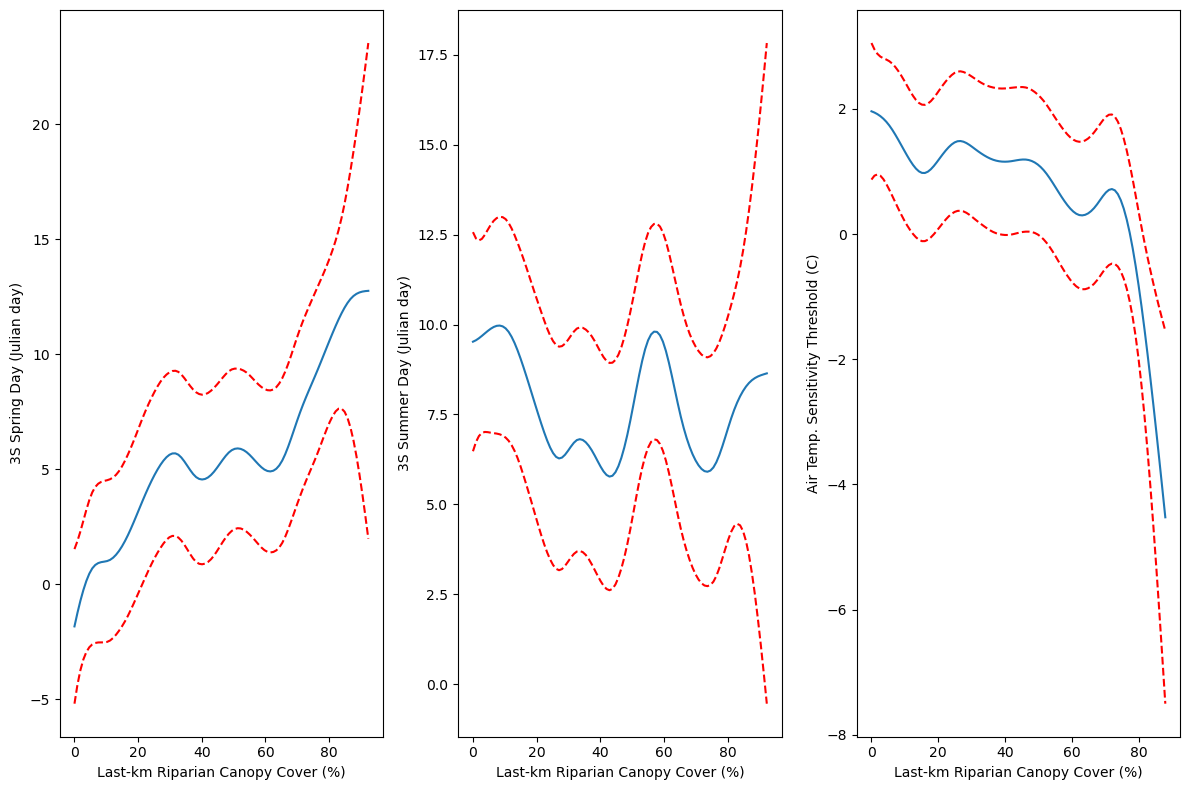

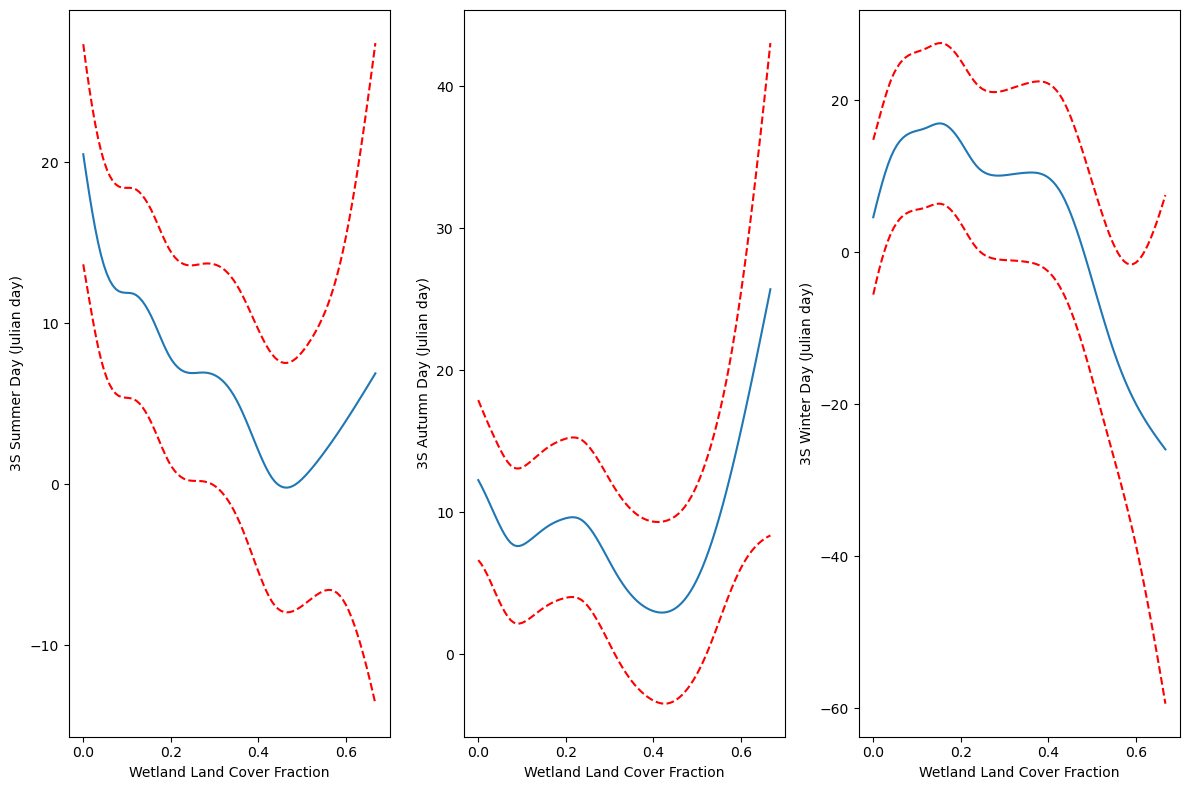

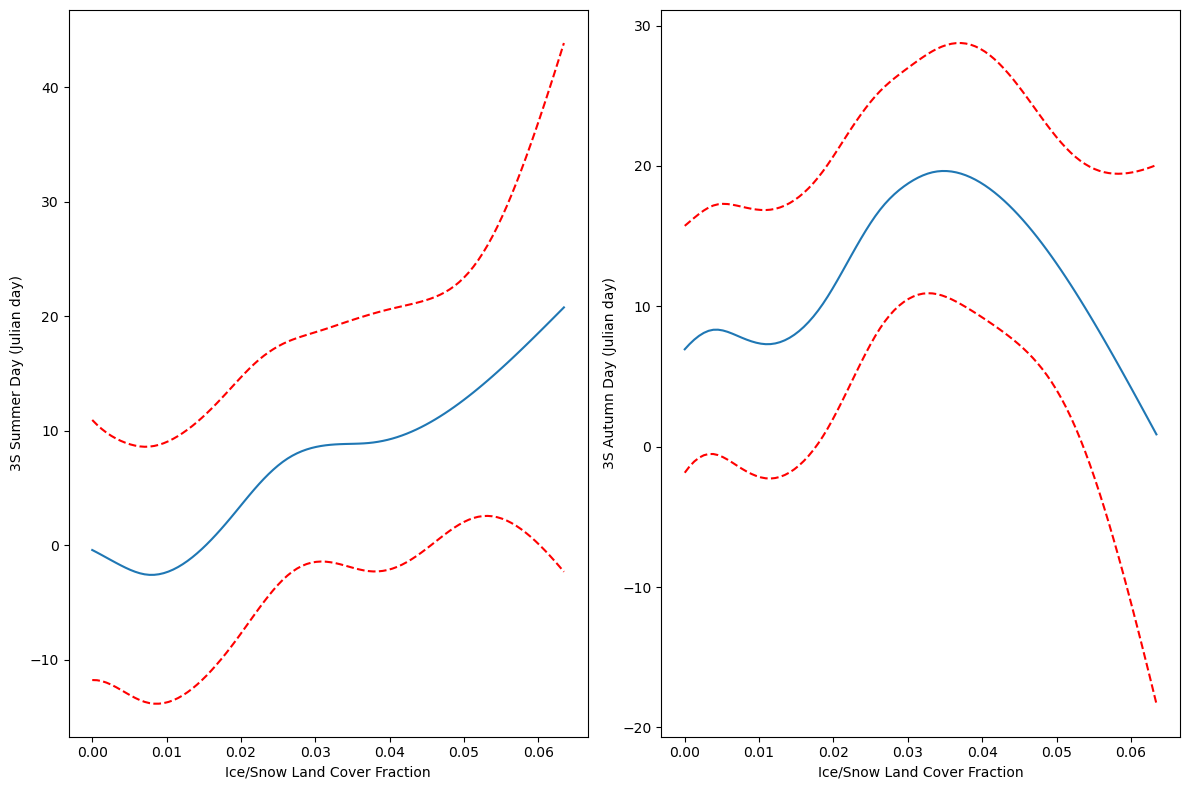

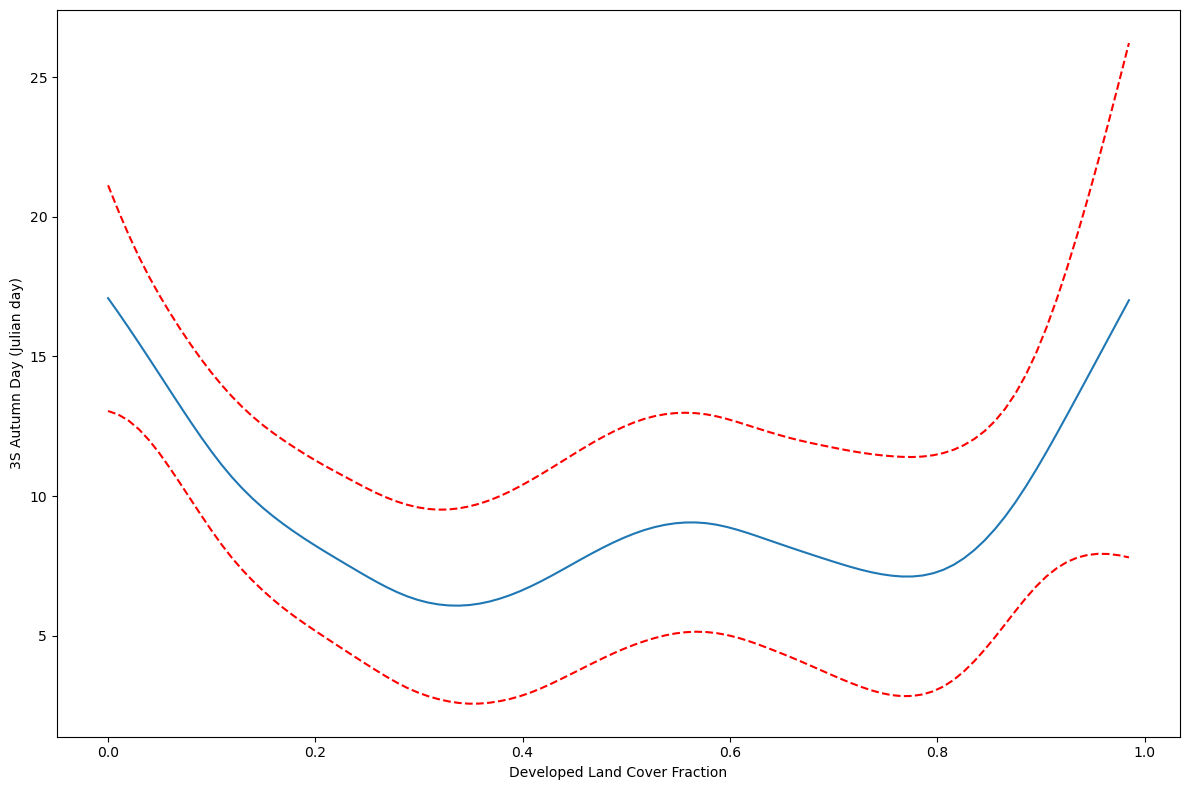

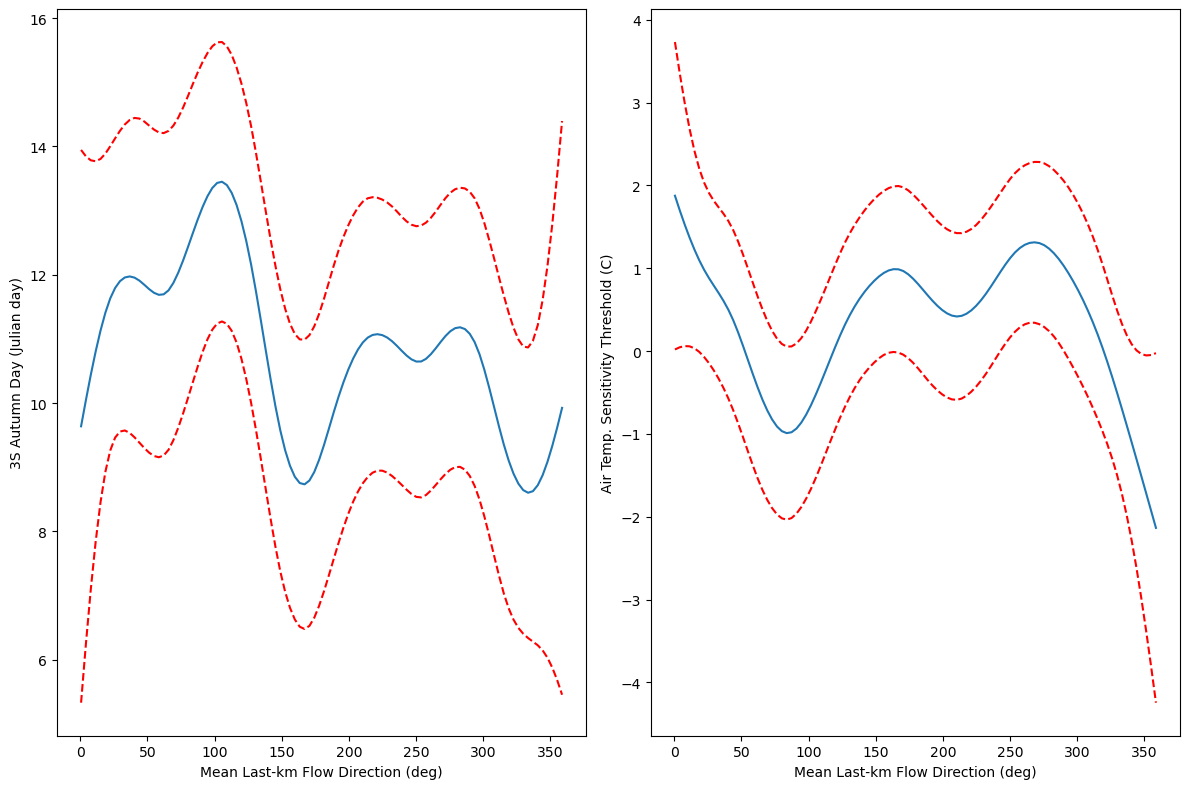

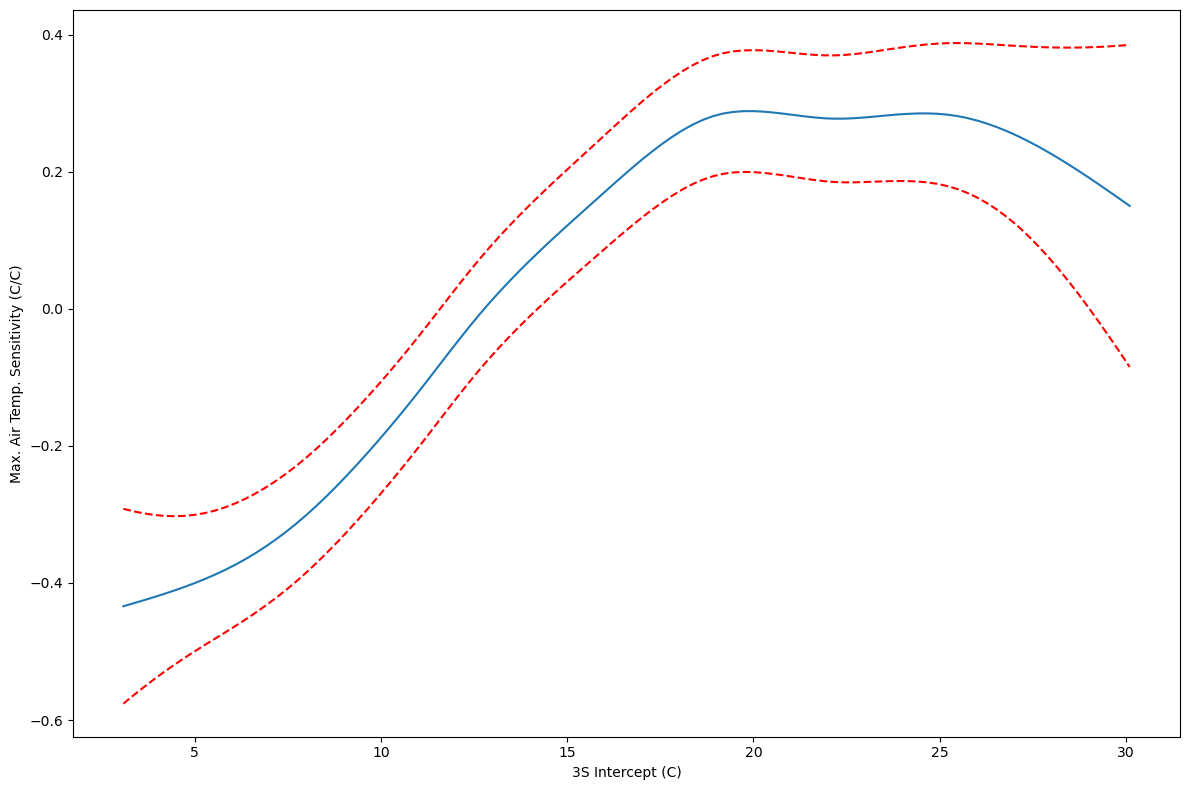

In [99]:
# (gam, xnames, simple_xnames, yname)
savebase = bp + "results/PDPs/PDPbyX_"
allgams = [
    (gam_itx, rename(var_itx), var_itx, "3S Intercept (C)"),
    (gam_amp, rename(var_amp), var_amp, "3S Amplitude (C)"),
    (gam_ssu, rename(var_ssu), var_ssu, "3S Spring/Summer Coefficient (C)"),
    (gam_fw, rename(var_fw), var_fw, "3S Autumn/Winter Coefficient (C)"),
    (gam_spd, rename(var_spd), var_spd, "3S Spring Day (Julian day)"),
    (gam_sud, rename(var_sud), var_sud, "3S Summer Day (Julian day)"),
    (gam_fad, rename(var_fad), var_fad, "3S Autumn Day (Julian day)"),
    (gam_wid, rename(var_wid), var_wid, "3S Winter Day (Julian day)"),
    (gam_tcmin, rename(var_tcmin), var_tcmin, "Min. Air Temp. Sensitivity (C/C)"),
    (gam_tcmax, rename(var_tcmax), var_tcmax, "Max. Air Temp. Sensitivity (C/C)"),
    (gam_tcc, rename(var_tcc), var_tcc, "Air Temp. Sensitivity Threshold (C)")
]
pdps_by_x(allgams, savebase)

# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  First, we'll go fine-tune the GAMs.

## New GAMs

In [100]:
# Run this to build list...
print("var_sets = [")
for (vr, nm) in [("itx", "Intercept"), ("amp", "Amplitude"), ("ssu", "SpringSummer"),
                 ("fw", "FallWinter"), ("spd", "SpringDay"), ("sud", "SummerDay"),
                 ("fad", "FallDay"), ("wid", "WinterDay"),
                 # ("atc", "at_coef")
                 ("tcmax", "threshold_coef_max"), ("tcmin", "threshold_coef_min"), ("tcc", "threshold_act_cutoff")
                ]:
    vrs = eval("var_" + vr)
    eq = eval("eq_" + vr)
    lam = eval("lam_" + vr)
    print(f'    {{"name": "{nm}", "vars": {vrs}, "eq": {eq}, "lam": {lam}}},')
    # print(f"var_{vr} = {eval('var_' + vr)}")
    # print(f"eq_{vr} = {eval('eq_' + vr)}")
    # print(f"lam_{vr} = {eval('lam_' + vr)}")
print("]")

var_sets = [
    {"name": "Intercept", "vars": ['intercept', 'cold_prcp', 'frozen', 'area', 'elev_min'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
    {"name": "Amplitude", "vars": ['frozen', 'water', 'forest', 'area', 'elev', 'elev_min', 'prcp_sd', 'vp', 'ssn_phi', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 50},
    {"name": "SpringSummer", "vars": ['intercept', 'prcp', 'cold_prcp', 'frozen', 'water', 'elev', 'elev_min', 'prcp_sd', 'srad_sd', 'vp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 10},
    {"name": "FallWinter", "vars": ['intercept', 'frozen', 'srad', 'water', 'forest', 'elev', 'slope', 'lat', 'lon', 'vp', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11), "lam": 10},
    {"name": "SpringDay", "vars": ['intercept', 'elev', 'lat', 'lon', 'ssn_phi', 'ssn_index', 'tamp', 'canopy'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) 

In [2]:
var_sets = [
    {"name": "Intercept", "vars": ['intercept', 'cold_prcp', 'frozen', 'area', 'elev_min'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
    {"name": "Amplitude", "vars": ['frozen', 'water', 'forest', 'area', 'elev', 'elev_min', 'prcp_sd', 'vp', 'ssn_phi', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 50},
    {"name": "SpringSummer", "vars": ['intercept', 'prcp', 'cold_prcp', 'frozen', 'water', 'elev', 'elev_min', 'prcp_sd', 'srad_sd', 'vp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9), "lam": 10},
    {"name": "FallWinter", "vars": ['intercept', 'frozen', 'srad', 'water', 'forest', 'elev', 'slope', 'lat', 'lon', 'vp', 'ssn_phi', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12), "lam": 10},
    {"name": "SpringDay", "vars": ['intercept', 'elev', 'lat', 'lon', 'ssn_phi', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6), "lam": 10},
    {"name": "SummerDay", "vars": ['prcp', 'cold_prcp', 'frozen', 'wetland', 'ice_snow', 'elev', 'lat', 'lon', 'prcp_sd', 'srad_sd', 'vp', 'ssn_index', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12), "lam": 10},
    {"name": "FallDay", "vars": ['srad', 'water', 'developed', 'forest', 'wetland', 'ice_snow', 'elev_min', 'lat', 'lon'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8), "lam": 10},
    {"name": "WinterDay", "vars": ['frozen', 'water', 'forest', 'wetland', 'srad_sd', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5), "lam": 10},
    {"name": "threshold_coef_max", "vars": ['Intercept', 'intercept', 'frozen', 'srad', 'water', 'area', 'lat', 'lon', 'ssn_index'], "eq": s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8), "lam": 10},
    {"name": "threshold_coef_min", "vars": ['intercept', 'frozen', 'srad', 'elev', 'tamp'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
    {"name": "threshold_act_cutoff", "vars": ['frozen', 'elev_min', 'lat', 'lon', 'srad_sd'], "eq": s(0) + s(1) + s(2) + s(3) + s(4), "lam": 10},
]

In [3]:
shared = list(set(sum([v["vars"] for v in var_sets], start=[])))
# shared = ['atmax', 'ssn_index', 'vp', 'prcp_sd', 'ssn_phi', 'tamp', 'elev', 'srad', 'water', 'prcp', 'Intercept', 'Amplitude', 'atmin', 'intercept', 'srad_sd', 'slope', 'frozen', 'cold_prcp', 'forest']
names = ["Intercept", "Amplitude", "SpringSummer", "FallWinter", "SpringDay", "SummerDay", "FallDay", "WinterDay",
         # "at_coef"
         "threshold_coef_max", "threshold_coef_min", "threshold_act_cutoff"
        ]
allvar = list(set(shared + names))

In [3]:
# gam_data = data[["id", "date", "day", "tmax", "temperature"]].merge(pds[shared + names + ["id"]], on="id")
# gam_data.to_csv("GAMData.csv", index=False)
gam_data = pd.read_csv("GAMData.csv", dtype={"id": "str"})
gam_data["date"] = pd.to_datetime(gam_data["date"])

In [2]:
def gam_modbuilder(data):
    vars_local = var_sets.copy()
    print("preparing data", end=" | ")
    idd = data.groupby("id")[allvar].mean()
    # builder = lambda eq, lamd, cols, yn, cd=idd: LinearGAM(eq, lam=lamd).fit(cd[cols], cd[yn])
    predictor = lambda cols, gam, ws: gam.predict(ws[cols])[0]
    print("Training models", end=" | ")
    for vs in vars_local:
        cd = idd if not vs["name"] in ["threshold_coef_min", "threshold_act_cutoff"] else idd[idd["threshold_act_cutoff"] > -1]
        vs["gam"] = LinearGAM(vs["eq"], lam=vs["lam"]).fit(cd[vs["vars"]], cd[vs["name"]])
    print("Trained models")
    def runner(ws):
        # print(f"Running {ws['id'].iloc[0]}")
        # try:
        at_day = ws.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        statics = ws[shared].mean().to_frame().T
        for vs in vars_local:  # Essential: sensitivity stuff is LAST - it uses Intercept, Amplitude
            statics[vs["name"]] = predictor(vs["vars"], vs["gam"], statics)
        ssn = rts.ThreeSine(
            Intercept=statics["Intercept"].iloc[0],
            Amplitude=statics["Amplitude"].iloc[0],
            SpringSummer=statics["SpringSummer"].iloc[0],
            FallWinter=statics["FallWinter"].iloc[0],
            SpringDay=statics["SpringDay"].iloc[0],
            SummerDay=statics["SummerDay"].iloc[0],
            FallDay=statics["FallDay"].iloc[0],
            WinterDay=statics["WinterDay"].iloc[0]
        )
        min_temp = ssn.generate_ts()["actemp"].min()
        min_temp = min_temp if min_temp > 0 else 0
        model = Watershed(seasonality=ssn,
                          at_coef=statics["threshold_coef_max"].iloc[0],
                          # at_coef=statics["at_coef"].iloc[0],
                          at_day=at_day,
                          dynamic_period=7,
                          dynamic_engine=engines.ThresholdSensitivityEngine(
                              act_min=min_temp,
                              coef_min=statics["threshold_coef_min"].iloc[0],
                              act_cutoff=statics["threshold_act_cutoff"].iloc[0],
                              coef_max=statics["threshold_coef_max"].iloc[0]
                          )
                         )
        return model.run_series(ws)
        # except Exception as e:
        #     print(e)
    return runner

In [3]:
gam_data = None
kfr = kfold(gam_data, gam_modbuilder, output="results/SmarterGAM_th.csv", redo=False)

In [4]:
perf_summary(kfr)

R2      RMSE       NSE   AnomNSE  AnomNSEAdvantage     Pbias  \
0  0.878839  2.714264  0.877482  0.714458         -0.252823  2.002318   

       Bias   MaxMiss  
0  0.263111  9.334931

In [5]:
kfr.groupby("id").apply(perf_summary, include_groups=False).describe()

R2        RMSE         NSE     AnomNSE  AnomNSEAdvantage  \
count  923.000000  923.000000  923.000000  923.000000        923.000000   
mean     0.901195    2.377143    0.408556    0.378827         -0.393123   
std      0.119515    1.174321    5.797066    0.575121          0.612719   
min      0.005189    1.011620 -166.240387  -10.232109        -11.140065   
25%      0.895779    1.785138    0.798683    0.278347         -0.532451   
50%      0.935596    2.109667    0.895847    0.503003         -0.267166   
75%      0.955031    2.643648    0.933522    0.640823         -0.078566   
max      0.981551   21.630528    0.977387    0.804803          0.166135   

            Pbias        Bias     MaxMiss  
count  923.000000  923.000000  923.000000  
mean     3.620391    0.250526    2.940411  
std     13.691177    1.497137    2.970112  
min    -69.135764  -20.904658   -9.782145  
25%     -2.954525   -0.391355    1.278167  
50%      2.167141    0.291357    2.969612  
75%      7.206390    0.919178    4.663749  
max    141.926586    6.843535   26.811001

Oddly, the "smart GAMs" are doing slightly worse than the "naive GAMs", though global R2 is much better.  Mainly, RMSE is marginally higher (2.3 vs 2.2 C median).  The plots show the usual mix of some near-perfect fits and some wildly off, with everything in between.

One possibility is that the relatively high lambdas, or likewise the aggressive paring-down, hinder cross-validation performance.  Performance characteristics shown suggest that the amplitude terms or the weather sensitivity may be faring poorly.  It's also possible that the intercept-normalizing of the amplitude coefficients was a net negative.

Allowing more flexibility helped but did not fully address the problem.  Likewise for non-normalizing.

I do wonder if the threshold behavior might be hurting rather than helping, since it seems rather hard to predict threshold coefficients.  The last resort would be that we really need the point-area data.

Excluding thresholds makes performance worse, though it does make the model ~3x faster.  The other last resort is to see what happens if we do include elevation.

Or, I may have been too aggressive about excluding covariates.

- Initial test: R2 0.94 (global 0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.8% (2.0%) = 0.34 (0.26) C, max miss 3.0 (14.1) C
- More flexible: R2 0.94 (0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.1% (2.0%) = 0.27 (0.27) C, max miss 2.9 (12.3) C
- Non-normalized: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88, bias 2.5% (1.9%) = 0.35 (0.25) C, max miss 3.0 (12.2) C
- No threshold: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88 (0.87), bias 2.6% (2.0%) = 0.35 (0.26) C, max miss 3.3 (12.3) C
- Smarter GAMs (with threshold): R2 0.94 (0.88), RMSE 2.1 (2.7) C, NSE 0.90 (0.88), bias 2.2% (2.0%) = 0.29 (0.26) C, max miss 3.0 (9.3) C

Now we're talking!  And the major problem does seem to be anomaly prediction, but this version is good enough for now.

The anomaly NSE is actually surprisingly good, at 0.50 (better than TE2, oddly), but, oddly, that's worse than stationary ("same as yesterday").  In TempEst 2, stationary NSE was ~0.2.  Not sure what happened there.  Though, of course, for ungaged watersheds we don't *have* an observation for yesterday, so it's still an improvement and considerably better than climatology (NSE = 0).

In [6]:
rng = np.random.default_rng()
ids = rng.choice(kfr["id"].unique(), 8)

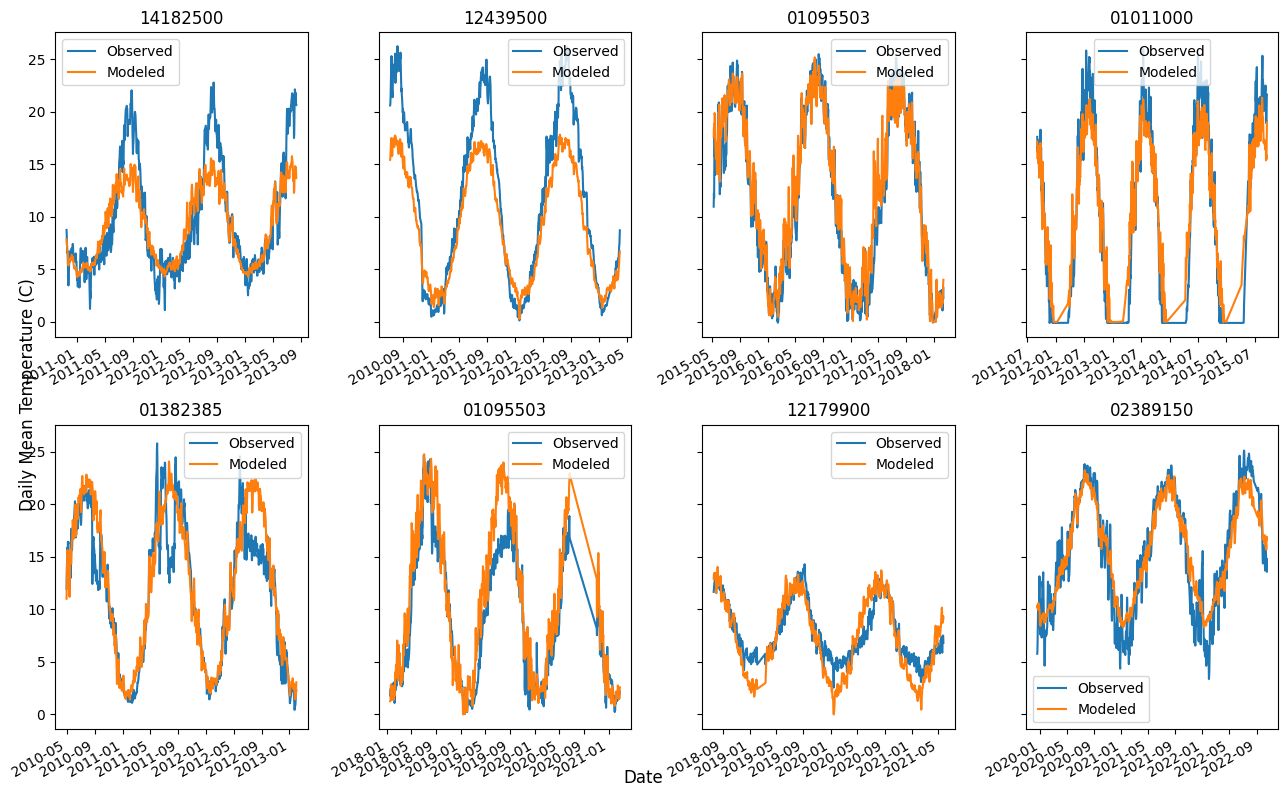

In [7]:
Ny = 2
Nx = 4
fig, axes = plt.subplots(Ny, Nx, figsize=(13, 8), sharey=True)
for i, ID in enumerate(ids):
    ax = axes[i // Nx, i % Nx]
    dat = kfr[kfr["id"] == ID]
    if len(dat) > 1100:
        start = rng.integers(0, len(dat) - 1000)
        dat = dat.iloc[start:(start + 1000), :]
    dat.plot(x="date", y="temperature", label="Observed", ax=ax)
    dat.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(ID)

plt.tight_layout()
fig.supxlabel("Date")
_ = fig.supylabel("Daily Mean Temperature (C)")

plt.savefig("results/SmarterGAMSample.png", dpi=1000)